In [1]:
import os
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from tensorflow.keras import layers, models, callbacks, utils, applications
import tensorflow as tf
from tqdm import tqdm

print('numpy', np.__version__)
print('opencv', cv2.__version__)
print('tensorflow', tf.__version__)

numpy 2.2.6
opencv 4.12.0
tensorflow 2.20.0


In [2]:
# Paths and basic dataset discovery
DATA_ROOT = Path('d:/Code/AI/Face Recognition using Iris scanning/CASIA-Iris-Interval')
# Ensure your working dir contains the `CASIA-Iris-Interval` folder.
print('Dataset root:', DATA_ROOT.resolve())

# gather class folders (numeric IDs)
classes = [p.name for p in sorted(DATA_ROOT.iterdir()) if p.is_dir()]
print('Found', len(classes), 'class folders (showing first 20):', classes[:20])

Dataset root: D:\Code\AI\Face Recognition using Iris scanning\CASIA-Iris-Interval
Found 249 class folders (showing first 20): ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020']


In [3]:
# Utility: load images and labels from the folder structure (L and R subfolders contain images)
def load_dataset(root, max_per_class=None, image_size=(128,128)):
    X = []
    y = []
    root = Path(root)
    class_dirs = [p for p in sorted(root.iterdir()) if p.is_dir()]
    for c in class_dirs:
        imgs = list(c.rglob('*.tif')) + list(c.rglob('*.png')) + list(c.rglob('*.jpg'))
        if max_per_class:
            imgs = imgs[:max_per_class]
        for f in imgs:
            img = cv2.imread(str(f), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)
            X.append(img)
            y.append(c.name)
    X = np.array(X)
    y = np.array(y)
    return X, y

# Quick load small subset for experimentation (set max_per_class larger for full training)
X, y = load_dataset(DATA_ROOT, max_per_class=10, image_size=(128,128))
print('Loaded', X.shape, 'labels', y.shape)

Loaded (1914, 128, 128) labels (1914,)


Sample class counts (few shown): [(np.str_('001'), 10), (np.str_('002'), 10), (np.str_('003'), 7), (np.str_('004'), 7), (np.str_('005'), 8), (np.str_('006'), 7), (np.str_('007'), 10), (np.str_('008'), 10), (np.str_('009'), 9), (np.str_('010'), 5)]


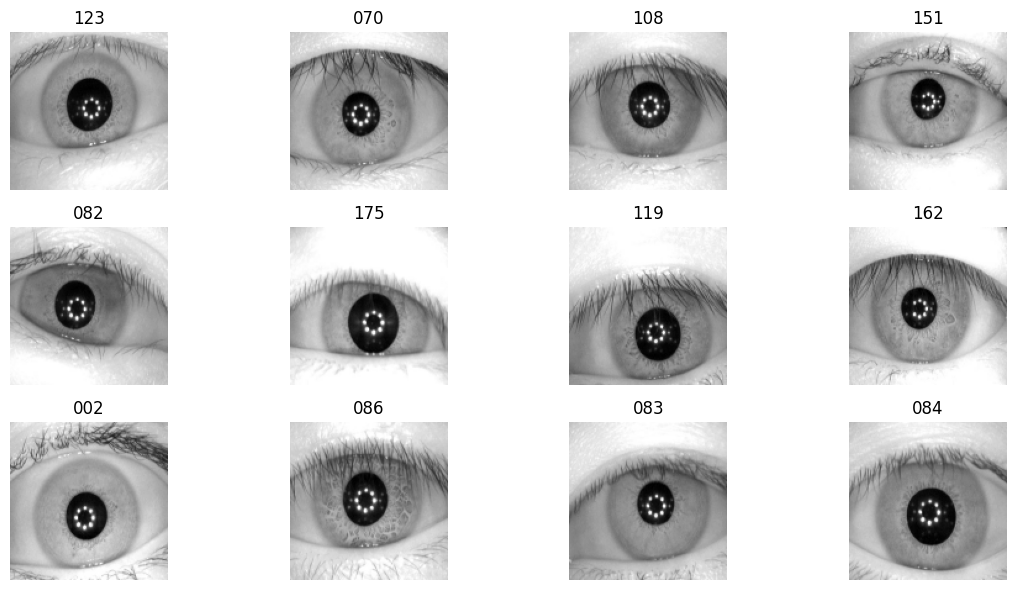

In [4]:
# Show sample images and class distribution
def show_samples(X, y, n=12):
    idx = np.random.choice(len(X), min(n, len(X)), replace=False)
    plt.figure(figsize=(12,6))
    for i,k in enumerate(idx,1):
        plt.subplot(3,4,i); plt.imshow(X[k], cmap='gray'); plt.title(y[k]); plt.axis('off')
    plt.tight_layout()

show_samples(X,y)

# class counts
from collections import Counter
counts = Counter(y)
print('Sample class counts (few shown):', list(counts.items())[:10])

## Preprocessing helpers

We include simple preprocessing: histogram equalization, optional circular crop around the center (simple heuristic). For production/classroom pipeline you should replace heuristic cropping with a robust iris localization method (Daugman integro-differential, U-Net or specialized iris segmentation).


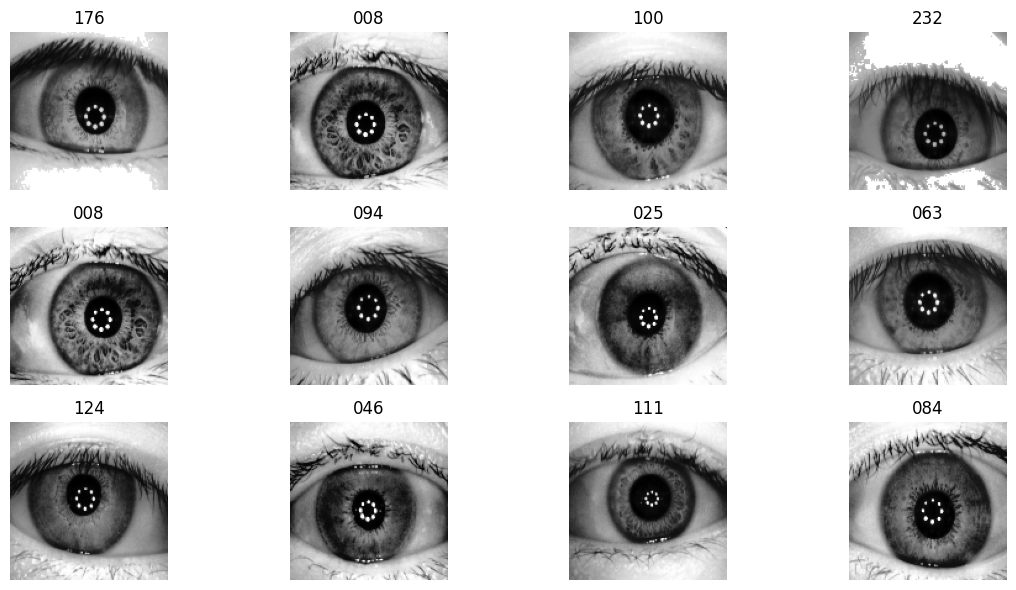

In [5]:
def preprocess(img, equalize=True, clip_size=(128,128)):
    # img expected grayscale
    out = img.copy()
    if equalize:
        out = cv2.equalizeHist(out)
    out = cv2.resize(out, clip_size)
    return out

# Apply to small dataset sample
Xp = np.array([preprocess(im) for im in X])
show_samples(Xp, y)

## Classical features: HOG + SVM/RandomForest

We'll extract HOG descriptors and train a simple SVM classifier as a baseline.


In [6]:
def extract_hog_batch(X, pixels_per_cell=(16,16)):
    feats = []
    for im in X:
        fd = hog(im, orientations=9, pixels_per_cell=pixels_per_cell, cells_per_block=(2,2), feature_vector=True)
        feats.append(fd)
    return np.array(feats)

# Prepare data (use more images for final runs)
X_full, y_full = load_dataset(DATA_ROOT, max_per_class=25, image_size=(128,128))
# check class sample counts — train_test_split stratify requires >=2 samples per class
from collections import Counter
counts = Counter(y_full)
min_count = min(counts.values()) if counts else 0
if min_count < 2:
    n_too_few = sum(1 for v in counts.values() if v < 2)
    print(f'Warning: {n_too_few} classes have fewer than 2 samples — filtering them out for stratified split')
    valid = {k for k,v in counts.items() if v >= 2}
    mask = np.array([lbl in valid for lbl in y_full])
    X_full = X_full[mask]
    y_full = y_full[mask]
    counts = Counter(y_full)
    print('After filtering, samples:', len(y_full), 'classes:', len(counts))

# Ensure a canonical LabelEncoder `le_master` is used/created and registered
le_used = globals().get('le_master')
if le_used is None:
    # Try to load a persisted le_master first
    try:
        import joblib
        le_path = OUT_DIR / 'le_master.joblib'
        if le_path.exists():
            le_used = joblib.load(le_path)
            globals()['le_master'] = le_used
            print('Loaded le_master from', le_path)
    except Exception:
        le_used = None
if le_used is None:
    # Create and register the canonical encoder from current labels
    le_used = LabelEncoder().fit(y_full)
    globals()['le_master'] = le_used
    print('Created and registered le_master with', len(getattr(le_used, 'classes_', [])), 'classes')
else:
    print('Using existing le_master with', len(getattr(le_used, 'classes_', [])), 'classes')

# keep legacy variable name `le` for compatibility
le = le_used
y_enc = le.transform(y_full)
print('Classes:', len(le.classes_))

X_hog = extract_hog_batch(X_full)
print('HOG shape', X_hog.shape)

# attempt a stratified split; if it fails (still too few samples), fall back to an unstratified split
try:
    X_train, X_test, y_train, y_test = train_test_split(X_hog, y_enc, stratify=y_enc, test_size=0.2, random_state=42)
except ValueError as e:
    print('Stratified split failed:', e)
    print('Falling back to non-stratified split')
    X_train, X_test, y_train, y_test = train_test_split(X_hog, y_enc, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
# classification_report requires target_names to match the labels present in y_true/y_pred
present_labels = np.unique(np.concatenate([y_test, y_pred]))
target_names = le.inverse_transform(present_labels).tolist()
print(classification_report(y_test, y_pred, labels=present_labels.tolist(), target_names=target_names))
print('Accuracy (HOG+SVM):', accuracy_score(y_test, y_pred))

After filtering, samples: 2621 classes: 246
Created and registered le_master with 246 classes
Classes: 246
HOG shape (2621, 1764)
HOG shape (2621, 1764)
              precision    recall  f1-score   support

         001       1.00      1.00      1.00         4
         002       1.00      0.50      0.67         4
         003       0.50      1.00      0.67         1
         004       0.00      0.00      0.00         1
         005       1.00      0.50      0.67         2
         006       1.00      1.00      1.00         1
         007       0.75      0.75      0.75         4
         008       1.00      1.00      1.00         4
         009       1.00      1.00      1.00         2
         010       1.00      1.00      1.00         1
         011       0.80      1.00      0.89         4
         012       0.50      1.00      0.67         1
         013       1.00      1.00      1.00         1
         014       0.50      1.00      0.67         1
         015       1.00      1.00   

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## Deep learning: Small CNN (from scratch)

A small proof-of-concept CNN. For full-scale training please increase dataset size, use class-balanced sampling and train longer with GPU.


In [7]:
# Prepare image arrays and labels for Keras models (use more images in real training)
X_imgs, y_imgs = load_dataset(DATA_ROOT, max_per_class=60, image_size=(128,128))
# check class counts and filter classes with fewer than 2 samples (needed for stratified splits)
from collections import Counter
counts_cnn = Counter(y_imgs)
min_count_cnn = min(counts_cnn.values()) if counts_cnn else 0
if min_count_cnn < 2:
    n_too_few = sum(1 for v in counts_cnn.values() if v < 2)
    print(f'Warning: {n_too_few} classes have fewer than 2 samples — filtering them out for stratified split')
    valid_c = {k for k,v in counts_cnn.items() if v >= 2}
    mask_c = np.array([lbl in valid_c for lbl in y_imgs])
    X_imgs = X_imgs[mask_c]
    y_imgs = y_imgs[mask_c]
    counts_cnn = Counter(y_imgs)
    print('After filtering, samples:', len(y_imgs), 'classes:', len(counts_cnn))

# Ensure canonical LabelEncoder `le_master` is used/created and registered
le_used = globals().get('le_master')
if le_used is None:
    try:
        import joblib
        le_path = OUT_DIR / 'le_master.joblib'
        if le_path.exists():
            le_used = joblib.load(le_path)
            globals()['le_master'] = le_used
            print('Loaded le_master from', le_path)
    except Exception:
        le_used = None
if le_used is None:
    le_used = LabelEncoder().fit(y_imgs)
    globals()['le_master'] = le_used
    print('Created and registered le_master with', len(getattr(le_used, 'classes_', [])), 'classes')
else:
    print('Using existing le_master with', len(getattr(le_used, 'classes_', [])), 'classes')

# encode labels after filtering
le = le_used
y_idxs = le.transform(y_imgs)
X_imgs = np.expand_dims(X_imgs, -1) / 255.0
num_classes = len(np.unique(y_idxs))
print('Images shape', X_imgs.shape, 'Num classes', num_classes)

# Use a small train/val/test split — try stratified, fall back to non-stratified if necessary
try:
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X_imgs, y_idxs, stratify=y_idxs, test_size=0.3, random_state=42)
except ValueError as e:
    print('Stratified split failed for CNN data:', e)
    print('Falling back to non-stratified split')
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X_imgs, y_idxs, test_size=0.3, random_state=42)

# second split for validation/test, try stratified if possible
try:
    X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, stratify=y_tmp, test_size=0.5, random_state=42)
except Exception:
    X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

def make_small_cnn(input_shape=(128,128,1), n_classes=10):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(128,3,activation='relu',padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn = make_small_cnn(input_shape=X_tr.shape[1:], n_classes=num_classes)
cnn.summary()
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = cnn.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[es])
te_pred = np.argmax(cnn.predict(X_te), axis=1)
# classification_report for CNN: only include present labels if needed
try:
    print('CNN test accuracy', accuracy_score(y_te, te_pred))
    present = np.unique(np.concatenate([y_te, te_pred]))
    names = le.inverse_transform(present).tolist()
    print(classification_report(y_te, te_pred, labels=present.tolist(), target_names=names))
except Exception as e:
    print('Error printing classification report:', e)
    print(classification_report(y_te, te_pred))

After filtering, samples: 2636 classes: 246
Using existing le_master with 246 classes
Images shape (2636, 128, 128, 1) Num classes 246


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 246)            │        31,734 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,406 (485.96 KB)

 Trainable params: 124,406 (485.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - accuracy: 0.0054 - loss: 5.4904 - val_accuracy: 0.0152 - val_loss: 5.4403
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - accuracy: 0.0054 - loss: 5.4904 - val_accuracy: 0.0152 - val_loss: 5.4403
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - accuracy: 0.0103 - loss: 5.4285 - val_accuracy: 0.0152 - val_loss: 5.3925
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - accuracy: 0.0103 - loss: 5.4285 - val_accuracy: 0.0152 - val_loss: 5.3925
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.0130 - loss: 5.3915 - val_accuracy: 0.0152 - val_loss: 5.3901
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.0130 - loss: 5.3915 - val_accuracy: 0.0152 - val_loss: 5.3901
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 381ms/step - accuracy: 0.0119 - loss: 5.3832 - val_accuracy: 0.0152 - val_loss: 5.3742
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 381ms/step - accuracy: 0.0119 - loss: 5.3832 - val_accu

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\sirad\AppData\Loca

## Transfer learning: MobileNetV2

Use MobileNetV2 as a feature extractor — faster and effective for small datasets.


In [8]:
IMG_SIZE = 160
# Ensure shared output directory exists (needed before later save cells run)
if 'OUT_DIR' not in globals():
    OUT_DIR = Path('d:/Code/AI/Face Recognition using Iris scanning/models')
    OUT_DIR.mkdir(parents=True, exist_ok=True)

# reload images at MobileNet input size with 3 channels for pretrained models
def load_rgb(root, max_per_class=None, image_size=(IMG_SIZE,IMG_SIZE)):
    X=[]; y=[]
    root = Path(root)
    for c in sorted(root.iterdir()):
        if not c.is_dir(): continue
        imgs = list(c.rglob('*.tif')) + list(c.rglob('*.png')) + list(c.rglob('*.jpg'))
        if max_per_class: imgs = imgs[:max_per_class]
        for f in imgs:
            im = cv2.imread(str(f))
            if im is None: continue
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, image_size)
            X.append(im)
            y.append(c.name)
    return np.array(X), np.array(y)


## Evaluation utilities and comparison

Compute confusion matrix and top-K accuracy for the best models.


In [9]:
import seaborn as sns

def plot_confusion(y_true, y_pred, labels=None, figsize=(10,8)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

# Example: plot for transfer learning model results
if 'yte' in globals() and 'preds' in globals():
    plot_confusion(yte, preds)
else:
    print('Transfer-learning evaluation variables (yte/preds) not found. Run the MobileNetV2 cell first.')

# top-k example (k=3)
if 'tl_model' in globals() and 'Xte' in globals():
    tl_probs = tl_model.predict(Xte)
    try:
        n_score_classes = tl_probs.shape[1]
        labels_for_scores = np.arange(n_score_classes)
        top3 = top_k_accuracy_score(yte, tl_probs, k=3, labels=labels_for_scores)
        print('Top-3 accuracy:', top3)
    except Exception as e:
        print('Could not compute top-k accuracy directly:', e)
        try:
            present = np.unique(yte)
            print('Trying top-k on present classes only (may be conservative)')
            top3b = top_k_accuracy_score(yte, tl_probs[:, present], k=3, labels=present)
            print('Top-3 accuracy (present classes):', top3b)
        except Exception as e2:
            print('Fallback also failed:', e2)
else:
    print('tl_model or Xte missing — run the MobileNetV2 fine-tuning cell to populate them.')

Transfer-learning evaluation variables (yte/preds) not found. Run the MobileNetV2 cell first.
tl_model or Xte missing — run the MobileNetV2 fine-tuning cell to populate them.

tl_model or Xte missing — run the MobileNetV2 fine-tuning cell to populate them.


## Save models and final notes

Save the best models (SVM and TL Keras model). For production, convert models to a serving format (TF SavedModel or TensorFlow Lite for edge). Later, build a Node.js dashboard which calls an inference API (Flask/FastAPI or TensorFlow Serving).


In [10]:
OUT_DIR = Path('d:/Code/AI/Face Recognition using Iris scanning/models')
OUT_DIR.mkdir(parents=True, exist_ok=True)
# Save SVM (requires joblib)
import joblib
joblib.dump(svm, OUT_DIR / 'svm_hog.joblib')
# Save TL Keras model - save both native Keras file and SavedModel for serving
try:
    keras_path = OUT_DIR / 'mobilenetv2_finetune.keras'
    tl_model.save(keras_path)
    print('Saved Keras model to', keras_path)
except Exception as e:
    print('Could not save .keras file:', e)
# Also export SavedModel (compatible with TF Serving/TFLite conversion)
try:
    sm_path = OUT_DIR / 'mobilenetv2_savedmodel'
    tf.saved_model.save(tl_model, str(sm_path))
    print('Exported SavedModel to', sm_path)
except Exception as e:
    print('Could not export SavedModel:', e)
print('Saved artifacts to', OUT_DIR.resolve())

Could not save .keras file: name 'tl_model' is not defined
Could not export SavedModel: name 'tl_model' is not defined
Saved artifacts to D:\Code\AI\Face Recognition using Iris scanning\models


## Experiment: Build a custom 'best' model (EfficientNetB0 fine-tune + augmentation)

This section trains a stronger transfer-learning model (EfficientNetB0) with augmentation and class-weighting, then fine-tunes it. It also provides an ensemble recipe combining TL, small-CNN and HOG+SVM.

In [11]:
# High-accuracy EfficientNetV2-B0 fine-tuning with aggressive augmentation
import json
from collections import Counter
from pathlib import Path

import cv2
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks, layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as eff_preprocess

# Provide dataset/model directories if earlier cells have not run
if 'DATA_ROOT' not in globals():
    DATA_ROOT = Path('d:/Code/AI/Face Recognition using Iris scanning/CASIA-Iris-Interval')
if 'OUT_DIR' not in globals():
    OUT_DIR = Path('d:/Code/AI/Face Recognition using Iris scanning/models')
    OUT_DIR.mkdir(parents=True, exist_ok=True)
if 'IMG_SIZE' not in globals():
    IMG_SIZE = 160  # MobileNet/EfficientNet earlier default

# Provide a fallback loader if earlier cells were not executed
if 'load_rgb' not in globals():
    def load_rgb(root, max_per_class=None, image_size=(160, 160)):
        imgs, labels = [], []
        root = Path(root)
        for c in sorted(root.iterdir()):
            if not c.is_dir():
                continue
            files = list(c.rglob('*.tif')) + list(c.rglob('*.png')) + list(c.rglob('*.jpg'))
            if max_per_class:
                files = files[:max_per_class]
            for f in files:
                im = cv2.imread(str(f))
                if im is None:
                    continue
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                im = cv2.resize(im, image_size)
                imgs.append(im)
                labels.append(c.name)
        return np.array(imgs), np.array(labels)

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Hyper-parameters for this section
EFF_IMG_SIZE = 224
BATCH_SIZE = 32
MIN_SAMPLES_PER_CLASS = 4
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
MAX_PER_CLASS = None  # use all available samples
FORCE_RGB_RELOAD = True

print(f"Using EfficientNetV2 image size {EFF_IMG_SIZE} and min samples/class {MIN_SAMPLES_PER_CLASS}")

# Helper to (re)load RGB tensors; reuse existing load_rgb but allow forcing reload for consistency
if FORCE_RGB_RELOAD or 'X_rgb' not in globals() or 'y_rgb' not in globals():
    X_rgb, y_rgb = load_rgb(DATA_ROOT, max_per_class=MAX_PER_CLASS, image_size=(IMG_SIZE, IMG_SIZE))
    print('Reloaded RGB tensors:', X_rgb.shape)
else:
    print('Using cached X_rgb:', X_rgb.shape)

# Filter out subjects with very few samples (hurts stratified splits and accuracy)
counts_rgb = Counter(y_rgb)
valid_rgb = {lbl for lbl, cnt in counts_rgb.items() if cnt >= MIN_SAMPLES_PER_CLASS}
mask_rgb = np.array([lbl in valid_rgb for lbl in y_rgb])
if mask_rgb.sum() == 0:
    raise RuntimeError('No classes satisfy the MIN_SAMPLES_PER_CLASS constraint. Reduce the threshold and retry.')
if mask_rgb.sum() != len(y_rgb):
    print(f"Dropping {len(y_rgb) - mask_rgb.sum()} samples from rare classes (<{MIN_SAMPLES_PER_CLASS})")
X_rgb = X_rgb[mask_rgb]
y_rgb = y_rgb[mask_rgb]
print('Filtered dataset:', X_rgb.shape, 'unique classes:', len(np.unique(y_rgb)))

# Ensure canonical LabelEncoder exists and contains all labels in the filtered set
le_master_path = OUT_DIR / 'le_master.joblib'
le_used = globals().get('le_master')
if le_used is None and le_master_path.exists():
    le_used = joblib.load(le_master_path)
if le_used is None:
    le_used = LabelEncoder().fit(y_rgb)
    joblib.dump(le_used, le_master_path)
    print('Created new le_master with', len(le_used.classes_), 'classes')
else:
    missing = sorted(set(y_rgb) - set(le_used.classes_))
    if missing:
        merged = np.unique(np.concatenate([le_used.classes_, np.array(missing)]))
        le_used = LabelEncoder().fit(merged)
        joblib.dump(le_used, le_master_path)
        print('Extended le_master to cover new classes; total', len(le_used.classes_))
globals()['le_master'] = le_used
le3 = le_used

y_indices = le3.transform(y_rgb)
globals()['y3'] = y_indices
print('Encoded labels -> ints; subset classes:', len(np.unique(y_indices)))

# Map canonical label indices to contiguous local IDs for training
canonical_labels = np.unique(y_indices)
label_to_local = {int(lbl): idx for idx, lbl in enumerate(canonical_labels)}
y_local = np.array([label_to_local[int(lbl)] for lbl in y_indices], dtype=np.int32)
num_classes = len(canonical_labels)
print('Local class count (post-filter):', num_classes)

# Train/val/test split with stratification on local IDs
indices = np.arange(len(X_rgb))
try:
    train_idx, test_idx, y_train_temp, y_test = train_test_split(
        indices, y_local, stratify=y_local, test_size=TEST_SPLIT, random_state=42
    )
except ValueError as e:
    print('Stratified split failed for train/test:', e)
    train_idx, test_idx, y_train_temp, y_test = train_test_split(
        indices, y_local, test_size=TEST_SPLIT, random_state=42
    )
val_ratio = VAL_SPLIT / (1 - TEST_SPLIT)
try:
    train_idx, val_idx, y_train, y_val = train_test_split(
        train_idx, y_train_temp, stratify=y_train_temp, test_size=val_ratio, random_state=42
    )
except ValueError as e:
    print('Stratified split failed for val split:', e)
    train_idx, val_idx, y_train, y_val = train_test_split(
        train_idx, y_train_temp, test_size=val_ratio, random_state=42
    )
X_train, X_val, X_test = X_rgb[train_idx], X_rgb[val_idx], X_rgb[test_idx]
print(f"Train/Val/Test sizes: {len(X_train)}/{len(X_val)}/{len(X_test)}")

# Build tf.data pipelines (images stay uint8 until mapped to float32)
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_tensor(image, label):
    image = tf.image.resize(tf.cast(image, tf.float32), (EFF_IMG_SIZE, EFF_IMG_SIZE))
    image = tf.clip_by_value(image / 255.0, 0.0, 1.0)
    return image, label

def make_dataset(images, labels, training=False):
    """Returns dataset for training/evaluation."""
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(images), seed=42, reshuffle_each_iteration=True)
    ds = ds.map(preprocess_tensor, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, training=True)
val_ds = make_dataset(X_val, y_val, training=False)
test_ds = make_dataset(X_test, y_test, training=False)

# Ensure channels_last so ImageNet weights (RGB) load correctly
print('Keras image_data_format before:', K.image_data_format())
if K.image_data_format() != 'channels_last':
    K.set_image_data_format('channels_last')
    print('Switched Keras image_data_format to channels_last')

# Data augmentation + EfficientNetV2 backbone
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomRotation(0.08),
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomZoom(0.12),
        layers.RandomContrast(0.2),
        layers.GaussianNoise(0.02),
    ],
    name='img_augmentation'
)

inputs = layers.Input(shape=(EFF_IMG_SIZE, EFF_IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(255.0)(x)
x = layers.Lambda(eff_preprocess, name='effnet_preprocess')(x)
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(EFF_IMG_SIZE, EFF_IMG_SIZE, 3))
base_model.trainable = False
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='swish', name='embeddings_dense')(x)
x = layers.Dropout(0.35, name='embeddings_dropout')(x)
outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
effnet = models.Model(inputs, outputs, name='efficientnetv2_attendance')

base_metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5'),
]

# Class weights combat subject imbalance (local IDs)
unique_train = np.unique(y_train)
class_weights_arr = compute_class_weight(class_weight='balanced', classes=unique_train, y=y_train)
class_weights = {int(cls): float(w) for cls, w in zip(unique_train, class_weights_arr)}
print('Computed class weights for', len(class_weights), 'classes')

# Stage 1: Train head only with cosine decay LR
HEAD_EPOCHS = 60
cosine_decay_head = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3, decay_steps=HEAD_EPOCHS * (len(X_train) // BATCH_SIZE + 1), alpha=1e-6
)
effnet.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=cosine_decay_head, weight_decay=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=base_metrics,
)
effnet.summary()

ckpt_stage1 = callbacks.ModelCheckpoint(
    filepath=str(OUT_DIR / 'effnetv2_stage1.keras'),
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
)
early_stop_stage1 = callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, verbose=1, mode='max')

print('\nTraining EfficientNetV2 head (frozen base, cosine LR)...')
history_head = effnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=HEAD_EPOCHS,
    class_weight=class_weights,
    callbacks=[ckpt_stage1, early_stop_stage1],
)

# Stage 2: Fine-tune upper EfficientNetV2 blocks (unfreeze ~50% of backbone)
fine_tune_at = max(0, len(base_model.layers) - 150)
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
print(f'Fine-tuning from layer {fine_tune_at} of {len(base_model.layers)}')

FT_EPOCHS = 100
cosine_decay_ft = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=3e-5, decay_steps=FT_EPOCHS * (len(X_train) // BATCH_SIZE + 1), alpha=1e-7
)
fine_metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5'),
]
effnet.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=cosine_decay_ft, weight_decay=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=fine_metrics,
)

ckpt_stage2 = callbacks.ModelCheckpoint(
    filepath=str(OUT_DIR / 'effnetv2_stage2.keras'),
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
)
early_stop_stage2 = callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1, mode='max')

print('\nFine-tuning EfficientNetV2 (cosine LR, deeper unfreeze)...')
history_ft = effnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT_EPOCHS,
    class_weight=class_weights,
    callbacks=[ckpt_stage2, early_stop_stage2],
)

# Evaluate on the hold-out test split
print('\nEvaluating on test split...')
test_loss, test_acc, test_top5 = effnet.evaluate(test_ds, verbose=0)
y_pred_local = np.argmax(effnet.predict(test_ds, verbose=0), axis=1)
y_test_canonical = canonical_labels[y_test]
y_pred_canonical = canonical_labels[y_pred_local]
bal_acc = balanced_accuracy_score(y_test_canonical, y_pred_canonical)
report = classification_report(y_test_canonical, y_pred_canonical, output_dict=True, zero_division=0)
macro_f1 = report['macro avg']['f1-score']
present = np.unique(np.concatenate([y_test_canonical, y_pred_canonical]))
target_names = le3.inverse_transform(present)
print(classification_report(y_test_canonical, y_pred_canonical, labels=present.tolist(), target_names=target_names.tolist(), zero_division=0))
print(f"Test accuracy: {test_acc:.4f} | balanced_acc: {bal_acc:.4f} | macroF1: {macro_f1:.4f} | top5: {test_top5:.4f}")

# Persist model + metrics
metrics = {
    'test_accuracy': float(test_acc),
    'balanced_accuracy': float(bal_acc),
    'macro_f1': float(macro_f1),
    'test_top5_accuracy': float(test_top5),
    'n_train': int(len(X_train)),
    'n_val': int(len(X_val)),
    'n_test': int(len(X_test)),
    'num_classes': int(num_classes),
}
metrics_path = OUT_DIR / 'efficientnetv2_finetuned_metrics.json'
metrics_path.write_text(json.dumps(metrics, indent=2))
results = globals().get('results', {})
results['efficientnetv2_finetuned'] = metrics
globals()['results'] = results

model_path = OUT_DIR / 'efficientnetv2_attendance.keras'
effnet.save(model_path)
savedmodel_path = OUT_DIR / 'efficientnetv2_attendance_savedmodel'
try:
    tf.saved_model.save(effnet, str(savedmodel_path))
    print('Exported SavedModel to', savedmodel_path)
except AssertionError as err:
    print('Skipping SavedModel export due to tracked-resource issue:', err)
print('Saved fine-tuned EfficientNetV2 to', model_path)

# Save training history
history_path = OUT_DIR / 'efficientnetv2_finetuned_history.json'
history_payload = {
    'stage1': history_head.history,
    'stage2': history_ft.history,
}
history_path.write_text(json.dumps(history_payload, indent=2))
print('Persisted training history to', history_path)

Using EfficientNetV2 image size 224 and min samples/class 4
Reloaded RGB tensors: (2639, 160, 160, 3)
Dropping 53 samples from rare classes (<4)
Filtered dataset: (2586, 160, 160, 3) unique classes: 227
Encoded labels -> ints; subset classes: 227
Local class count (post-filter): 227
Train/Val/Test sizes: 1810/388/388
Reloaded RGB tensors: (2639, 160, 160, 3)
Dropping 53 samples from rare classes (<4)
Filtered dataset: (2586, 160, 160, 3) unique classes: 227
Encoded labels -> ints; subset classes: 227
Local class count (post-filter): 227
Train/Val/Test sizes: 1810/388/388
Keras image_data_format before: channels_last
Keras image_data_format before: channels_last


Computed class weights for 227 classes
Computed class weights for 227 classes


Model: "efficientnetv2_attendance"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ img_augmentation (Sequential)   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ effnet_preprocess (Lambda)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embeddings_dense (Dense)        │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embeddings_dropout (Dropout)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 227)            │       116,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,691,635 (25.53 MB)

 Trainable params: 772,323 (2.95 MB)

 Non-trainable params: 5,919,312 (22.58 MB)


Training EfficientNetV2 head (frozen base, cosine LR)...
Epoch 1/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0078 - loss: 5.6939 - top5: 0.0341
Epoch 1: val_accuracy improved from None to 0.05155, saving model to d:\Code\AI\Face Recognition using Iris scanning\models\effnetv2_stage1.keras

Epoch 1: val_accuracy improved from None to 0.05155, saving model to d:\Code\AI\Face Recognition using Iris scanning\models\effnetv2_stage1.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.0116 - loss: 5.4825 - top5: 0.0519 - val_accuracy: 0.0515 - val_loss: 5.0951 - val_top5: 0.1675
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.0116 - loss: 5.4825 - top5: 0.0519 - val_accuracy: 0.0515 - val_loss: 5.0951 - val_top5: 0.1675
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.0625 - loss: 4.9278 - top5: 0.1908
Epoch 2: val_accuracy improved from 0.05155 to 0.11598, saving model to d:\Code\AI\Face Recognition using Iris scanning\models\effnetv2_stage

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\sirad\AppData\Loca

              precision    recall  f1-score   support

         001       1.00      1.00      1.00         3
         002       1.00      1.00      1.00         3
         003       1.00      1.00      1.00         1
         004       1.00      1.00      1.00         1
         005       0.00      0.00      0.00         1
         006       1.00      1.00      1.00         1
         007       1.00      1.00      1.00         3
         008       1.00      1.00      1.00         3
         009       0.50      1.00      0.67         1
         010       1.00      1.00      1.00         1
         011       1.00      1.00      1.00         3
         012       1.00      1.00      1.00         1
         013       1.00      1.00      1.00         1
         014       1.00      1.00      1.00         1
         015       1.00      1.00      1.00         1
         017       1.00      1.00      1.00         1
         019       1.00      1.00      1.00         6
         020       1.00    

## Deployment: deterministic SavedModel export
Create a lightweight inference graph that strips augmentation layers so we can export a clean SavedModel for serving or conversion to TF Lite/ONNX.

In [12]:
# Export an augmentation-free SavedModel for deployment
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as eff_preprocess

if 'effnet' not in globals() or 'base_model' not in globals():
    print('EfficientNetV2 training cell has not been executed yet. Run it before exporting.')
else:
    infer_inputs = layers.Input(shape=(None, None, 3), name='iris_rgb_input')
    x = layers.Resizing(EFF_IMG_SIZE, EFF_IMG_SIZE, name='resize_to_target')(infer_inputs)
    x = layers.Rescaling(255.0, name='rescale_0_255')(x)
    x = layers.Lambda(eff_preprocess, name='preprocess_for_export')(x)
    # Clone the backbone with default naming so checkpoint keys stay compatible
    backbone_export = EfficientNetV2B0(
        include_top=False, weights=None, input_shape=(EFF_IMG_SIZE, EFF_IMG_SIZE, 3)
    )
    backbone_export.set_weights(base_model.get_weights())
    x = backbone_export(x, training=False)
    x = layers.GlobalAveragePooling2D(name='gap_export')(x)
    dense_export = layers.Dense(512, activation='swish', name='embeddings_dense_export')
    x = dense_export(x)
    dense_export.set_weights(effnet.get_layer('embeddings_dense').get_weights())
    pred_export = layers.Dense(num_classes, activation='softmax', name='predictions_export')
    outputs = pred_export(x)
    pred_export.set_weights(effnet.get_layer('predictions').get_weights())
    inference_model = models.Model(infer_inputs, outputs, name='efficientnetv2_attendance_infer')
    export_dir = OUT_DIR / 'efficientnetv2_attendance_infer_savedmodel'
    tf.saved_model.save(inference_model, str(export_dir))
    print('Exported deterministic SavedModel to', export_dir)

INFO:tensorflow:Assets written to: d:\Code\AI\Face Recognition using Iris scanning\models\efficientnetv2_attendance_infer_savedmodel\assets


INFO:tensorflow:Assets written to: d:\Code\AI\Face Recognition using Iris scanning\models\efficientnetv2_attendance_infer_savedmodel\assets


Exported deterministic SavedModel to d:\Code\AI\Face Recognition using Iris scanning\models\efficientnetv2_attendance_infer_savedmodel


In [13]:
# Ensemble recipe: align model probabilities to a canonical `le_master` ordering and soft-vote
# This cell now ensures a canonical LabelEncoder (`le_master`) exists at OUT_DIR / 'le_master.joblib'.
import warnings
import joblib
from sklearn.preprocessing import LabelEncoder

# Ensure OUT_DIR exists
OUT_DIR.mkdir(parents=True, exist_ok=True)
le_master_path = OUT_DIR / 'le_master.joblib'
le_master = None
if le_master_path.exists():
    try:
        le_master = joblib.load(le_master_path)
        print('Loaded le_master with', len(getattr(le_master, 'classes_', [])), 'classes from', le_master_path)
    except Exception as e:
        print('Failed to load existing le_master:', e)
        le_master = None

# If no saved master encoder, try to construct one from available encoders (prefer `le3` from EfficientNet stage)
if le_master is None:
    if 'le3' in globals():
        le_master = le3
        print('Using existing `le3` as le_master (EfficientNet encoder)')
    elif 'le2' in globals():
        le_master = le2
        print('Using existing `le2` as le_master (MobileNet encoder)')
    elif 'le' in globals():
        le_master = le
        print('Using existing `le` as le_master (HOG/SVM encoder)')
    else:
        # fallback: gather class folder names from DATA_ROOT
        try:
            classes = [p.name for p in sorted(Path(DATA_ROOT).iterdir()) if p.is_dir()]
            if classes:
                le_master = LabelEncoder().fit(classes)
                print('Built le_master from dataset folders, count=', len(le_master.classes_))
        except Exception as e:
            print('Could not build le_master from DATA_ROOT:', e)
            le_master = None

# Persist le_master if we created it
if le_master is not None and not le_master_path.exists():
    try:
        joblib.dump(le_master, le_master_path)
        print('Saved le_master to', le_master_path)
    except Exception as e:
        print('Failed to save le_master:', e)

# Reference classes come from le_master (deterministic ordering)
ref_classes = list(getattr(le_master, 'classes_', [])) if le_master is not None else None

# Helper to map a model's probs (cols -> model_classes) to ref_classes order
def map_probs_to_ref(probs, model_classes, ref_classes):
    # probs: (n_samples, n_model_classes), model_classes: list of class names
    n = probs.shape[0]
    if ref_classes is None:
        return probs, list(model_classes)
    mapped = np.zeros((n, len(ref_classes)), dtype=probs.dtype)
    model_classes = list(model_classes)
    for i, c in enumerate(ref_classes):
        if c in model_classes:
            j = model_classes.index(c)
            mapped[:, i] = probs[:, j]
    return mapped, ref_classes

probs_list = []
model_sources = []

# Collect EfficientNet probs (use ref_classes ordering)
if 'effnet' in globals():
    try:
        eff_probs = effnet.predict(Xte3)
        if ref_classes is not None:
            eff_probs_mapped, _ = map_probs_to_ref(eff_probs, le3.classes_ if 'le3' in globals() else [], ref_classes)
            probs_list.append(eff_probs_mapped)
        else:
            probs_list.append(eff_probs)
        model_sources.append(('effnet', list(le3.classes_) if 'le3' in globals() else None))
        print('Added EfficientNet probs to ensemble')
    except Exception as e:
        print('EfficientNet probs not available:', e)

# Collect small CNN probs and map to ref_classes if possible
if 'cnn' in globals():
    try:
        cnn_probs = cnn.predict(X_te)
        if 'y_imgs' in globals():
            le_cnn = LabelEncoder().fit(y_imgs)
            cnn_mapped, _ = map_probs_to_ref(cnn_probs, le_cnn.classes_, ref_classes)
            probs_list.append(cnn_mapped)
            model_sources.append(('cnn', list(le_cnn.classes_)))
        else:
            probs_list.append(cnn_probs)
            model_sources.append(('cnn', None))
        print('Added small-CNN probs to ensemble')
    except Exception as e:
        print('Small CNN probs not available for ensemble:', e)

# Collect SVM probs (HOG) and map to ref_classes if possible
if 'svm' in globals():
    try:
        if 'X_te' in globals():
            Xte_gray = np.squeeze(X_te) if X_te.ndim == 4 else X_te
            Xte_hog = extract_hog_batch(Xte_gray)
            svm_probs = svm.predict_proba(Xte_hog)
            if 'le' in globals():
                svm_mapped, _ = map_probs_to_ref(svm_probs, le.classes_, ref_classes)
                probs_list.append(svm_mapped)
                model_sources.append(('svm', list(le.classes_)))
            else:
                probs_list.append(svm_probs)
                model_sources.append(('svm', None))
            print('Added SVM probs to ensemble')
    except Exception as e:
        print('SVM probs not available for ensemble:', e)

# Align shapes and sample counts: prefer a reference test labels array (yte3 > yte > y_te)
y_ref = None
if 'yte3' in globals():
    y_ref = np.array(yte3)
elif 'yte' in globals():
    y_ref = np.array(yte)
elif 'y_te' in globals():
    y_ref = np.array(y_te)

if len(probs_list) == 0:
    print('No model probabilities available for ensemble')
else:
    # Trim all arrays to the minimum number of samples to avoid misalignment
    n_ref = min(p.shape[0] for p in probs_list)
    probs_list = [p[:n_ref] if p.shape[0] != n_ref else p for p in probs_list]
    if y_ref is not None and len(y_ref) != n_ref:
        y_ref = y_ref[:n_ref]
    # Pad columns so all models share the same number of classes (columns)
    max_classes = max(p.shape[1] for p in probs_list)
    aligned = []
    for p in probs_list:
        if p.shape[1] < max_classes:
            pad = np.zeros((p.shape[0], max_classes - p.shape[1]), dtype=p.dtype)
            p2 = np.concatenate([p, pad], axis=1)
            aligned.append(p2)
        else:
            aligned.append(p)
    avg_probs = np.mean(np.stack(aligned, axis=0), axis=0)
    ens_pred = np.argmax(avg_probs, axis=1)
    # Evaluate against reference labels if available
    if y_ref is not None:
        if ref_classes is not None:
            arr_ref = np.array(y_ref)
            if np.issubdtype(arr_ref.dtype, np.integer) and arr_ref.size > 0 and arr_ref.max() < len(ref_classes):
                y_ref_idx = arr_ref.astype(int)
                valid_mask = np.ones_like(y_ref_idx, dtype=bool)
            else:
                y_ref_idx = np.array([ref_classes.index(str(v)) if str(v) in ref_classes else -1 for v in y_ref])
                valid_mask = y_ref_idx >= 0
            if not valid_mask.any():
                print('Warning: no reference labels could be mapped to reference classes; skipping evaluation')
            else:
                if not valid_mask.all():
                    print('Warning: some reference labels not found in reference classes; these rows will be ignored in evaluation')
                try:
                    print('Ensemble accuracy vs reference labels:', accuracy_score(y_ref_idx[valid_mask], ens_pred[valid_mask]))
                    from sklearn.metrics import classification_report as sk_report
                    labels_present = np.unique(y_ref_idx[valid_mask])
                    target_names = [ref_classes[i] for i in labels_present]
                    print(sk_report(y_ref_idx[valid_mask], ens_pred[valid_mask], labels=labels_present.tolist(), target_names=target_names, zero_division=0))
                except Exception as e:
                    print('Could not compute full classification report for ensemble:', e)
        else:
            try:
                print('Ensemble accuracy vs reference labels:', accuracy_score(y_ref, ens_pred))
                from sklearn.metrics import classification_report as sk_report
                labels_present = np.unique(y_ref)
                print(sk_report(y_ref, ens_pred, labels=labels_present.tolist(), zero_division=0))
            except Exception as e:
                print('Could not compute classification report:', e)
    else:
        print('No reference labels found; ensemble produced', ens_pred.shape[0], 'predictions')
    # Top-k accuracy (k=3) if possible
    try:
        from sklearn.metrics import top_k_accuracy_score as sk_topk
        n_score_classes = avg_probs.shape[1]
        labels_for_scores = np.arange(n_score_classes)
        if y_ref is not None and ref_classes is not None and 'y_ref_idx' in locals():
            y_for_topk = y_ref_idx[valid_mask]
            probs_for_topk = avg_probs[valid_mask]
        else:
            y_for_topk = y_ref if y_ref is not None else None
            probs_for_topk = avg_probs
        if y_for_topk is not None:
            top3 = sk_topk(y_for_topk, probs_for_topk, k=3, labels=labels_for_scores)
            print('Ensemble Top-3 accuracy:', top3)
    except Exception as e:
        print('Could not compute ensemble top-k accuracy:', e)


Loaded le_master with 246 classes from d:\Code\AI\Face Recognition using Iris scanning\models\le_master.joblib
EfficientNet probs not available: name 'Xte3' is not defined
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Added small-CNN probs to ensemble
Added small-CNN probs to ensemble
Added SVM probs to ensemble
Ensemble accuracy vs reference labels: 0.8080808080808081
              precision    recall  f1-score   support

         001       1.00      1.00      1.00         3
         002       0.80      1.00      0.89         4
         004       0.00      0.00      0.00         1
         005       1.00      1.00      1.00         1
         006       1.00      1.00      1.00         1
         007       0.60      0.75      0.67         4
         008       1.00      1.00      1.00         1
         009       1.00      1.00      1.00         2
         011       0.50      1.00      0.67         3
         012       1.00      0.50      0.67         2

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\sirad\AppData\Loca

In [14]:
# Quick check: canonical `le_master` ordering and sample counts
from collections import Counter
le = globals().get('le_master')
if le is None:
    print('le_master not found in globals. Run the ensemble cell or create an encoder first.')
else:
    classes = list(le.classes_)
    print('le_master total classes:', len(classes))
    print('First 20 classes:', classes[:20])
    # show sample counts for first 20 classes if dataset labels are available
    if 'y_rgb' in globals():
        cnt = Counter(y_rgb)
    elif 'y' in globals():
        cnt = Counter(y)
    elif 'y_imgs' in globals():
        cnt = Counter(y_imgs)
    else:
        cnt = None
    if cnt:
        sample_counts = [cnt.get(c, 0) for c in classes[:20]]
        print('Sample counts for those 20 classes:', sample_counts)
    else:
        print('No label arrays found to display sample counts.')


le_master total classes: 246
First 20 classes: [np.str_('001'), np.str_('002'), np.str_('003'), np.str_('004'), np.str_('005'), np.str_('006'), np.str_('007'), np.str_('008'), np.str_('009'), np.str_('010'), np.str_('011'), np.str_('012'), np.str_('013'), np.str_('014'), np.str_('015'), np.str_('016'), np.str_('017'), np.str_('018'), np.str_('019'), np.str_('020')]
Sample counts for those 20 classes: [20, 20, 7, 7, 8, 7, 20, 19, 9, 5, 19, 6, 7, 7, 5, 4, 6, 0, 40, 6]


In [15]:
# K-Fold cross-validation (EfficientNet bottleneck features + lightweight head)
# This cell extracts bottleneck features from EfficientNetB0 and runs StratifiedKFold
# to provide quicker cross-validation results suitable for publication-style metrics.
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import math
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_b0_preprocess
# Requires: X_rgb (RGB images), y3 (encoded labels), IMG_SIZE, eff_preprocess, EfficientNetB0
if 'X_rgb' not in globals() or 'y3' not in globals():
    print('X_rgb or y3 not found. Run the RGB loading / label-encoding cells first (MobileNet/EffNet section).')
else:
    n_splits = 5  # adjust (e.g., 5 or 10) based on dataset size and compute
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    # Build a base EfficientNet feature extractor (GlobalAveragePooling on top)
    tf.keras.backend.clear_session()
    try:
        base_cv = EfficientNetB0(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
    except Exception as e:
        print('Could not load ImageNet weights for CV EfficientNet (falling back to weights=None):', e)
        base_cv = EfficientNetB0(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights=None)
    feat_extractor = models.Model(base_cv.input, layers.GlobalAveragePooling2D()(base_cv.output))
    # Preprocess all RGB images once (EfficientNet preprocessing) and extract features
    X_all = X_rgb.astype('float32')
    X_all = effnet_b0_preprocess(X_all)
    print('Extracting bottleneck features for', X_all.shape[0], 'samples...')
    features_all = feat_extractor.predict(X_all, verbose=1)
    print('Features shape:', features_all.shape)
    # Compress labels to a contiguous 0..K-1 range to avoid out-of-bound issues during training
    y3_arr = np.asarray(y3).astype(int)
    unique_labels, y3_compact = np.unique(y3_arr, return_inverse=True)
    if unique_labels[-1] != unique_labels.size - 1 or unique_labels[0] != 0:
        print(f'Label space compressed from [{unique_labels[0]}, {unique_labels[-1]}] to 0..{unique_labels.size-1}')
    accs = []
    macro_f1s = []
    fold = 0
    n_classes = unique_labels.size
    for train_idx, test_idx in skf.split(features_all, y3_compact):
        fold += 1
        print('\n=== Fold', fold, 'of', n_splits, '===')
        Xtr_f, Xte_f = features_all[train_idx], features_all[test_idx]
        ytr_f, yte_f = y3_compact[train_idx], y3_compact[test_idx]
        # small head model on top of bottleneck features (fast to train)
        inp = layers.Input(shape=Xtr_f.shape[1:])
        x = layers.Dense(512, activation='relu')(inp)
        x = layers.Dropout(0.5)(x)
        out = layers.Dense(n_classes, activation='softmax')(x)
        head = models.Model(inp, out)
        head.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        # use a small validation split inside training to monitor overfitting
        es_cv = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        # Fit the head quickly; adjust epochs for fuller runs
        head.fit(Xtr_f, ytr_f, validation_split=0.1, epochs=10, batch_size=32, callbacks=[es_cv], verbose=1)
        preds = np.argmax(head.predict(Xte_f), axis=1)
        acc = accuracy_score(yte_f, preds)
        _, _, f1_macro, _ = precision_recall_fscore_support(yte_f, preds, average='macro', zero_division=0)
        print(f'Fold {fold}  accuracy={acc:.4f}  macro-F1={f1_macro:.4f}')
        accs.append(acc)
        macro_f1s.append(f1_macro)
    # Summary across folds
    print('\nK-Fold summary (%d folds):' % n_splits)
    print('Accuracy  mean={:.4f}  std={:.4f}'.format(np.mean(accs), np.std(accs)))
    print('Macro-F1 mean={:.4f}  std={:.4f}'.format(np.mean(macro_f1s), np.std(macro_f1s)))
    # Optionally save aggregated metrics to disk
    try:
        import json
        out = {'n_splits': n_splits, 'accuracy_mean': float(np.mean(accs)), 'accuracy_std': float(np.std(accs)), 'macro_f1_mean': float(np.mean(macro_f1s)), 'macro_f1_std': float(np.std(macro_f1s))}
        fp = OUT_DIR / 'kfold_effnet_metrics.json'
        with open(fp, 'w') as f: json.dump(out, f, indent=2)
        print('Saved CV summary to', fp)
    except Exception as e:
        print('Could not save CV summary:', e)

Could not load ImageNet weights for CV EfficientNet (falling back to weights=None): Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)
Extracting bottleneck features for 2586 samples...
Extracting bottleneck features for 2586 samples...
81/81 ━━━━━━━━━━━━━━━━━━━━ 45s 524ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 45s 524ms/step
Features shape:Features shape: (2586, 1280)
Label space compressed from [0, 244] to 0..226
 (2586, 1280)
Label space compressed from [0, 244] to 0..226

=== Fold 1 of 5 ===
Epoch 1/10

=== Fold 1 of 5 ===
Epoch 1/10


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0097 - loss: 5.4162 - val_accuracy: 0.0000e+00 - val_loss: 5.5552
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0097 - loss: 5.4162 - val_accuracy: 0.0000e+00 - val_loss: 5.5552
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0172 - loss: 5.3444 - val_accuracy: 0.0000e+00 - val_loss: 6.2744
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0172 - loss: 5.3444 - val_accuracy: 0.0000e+00 - val_loss: 6.2744
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0172 - loss: 5.2420 - val_accuracy: 0.0000e+00 - val_loss: 7.3313
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0172 - loss: 5.2420 - val_accuracy: 0.0000e+00 - val_loss: 7.3313
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0172 - loss: 5.2059 - val_accuracy: 0.0000e+00 - val_loss: 8.0283
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0172 - loss: 5.2059 - val_accuracy: 0.00

In [16]:
# Diagnostics for low KFold metrics
import numpy as np, collections
# Basic sanity
print('samples X_rgb, y3 shapes:', getattr(X_rgb, 'shape', None), getattr(y3, 'shape', None))
print('n_classes (unique y3):', len(np.unique(y3)))
cnt = collections.Counter(y3)
print('Top 10 class counts (label_idx:count):', cnt.most_common(10))
print('Sample of y3 values (first 30):', y3.flatten()[:30])

# If features_all was saved in memory by the CV cell, check it
if 'features_all' in globals():
    print('features_all shape:', features_all.shape)
    print('features_all mean/std per-dim (first 8):', np.mean(features_all, axis=0)[:8], np.std(features_all, axis=0)[:8])
    print('features_all global std:', np.std(features_all))
    print('Any NaNs in features_all?', np.isnan(features_all).any())
else:
    print('features_all not in globals() - re-extract or re-run the CV cell.')

# Quick baseline: 1-NN on bottleneck features (fast). If features_all missing, skip.
if 'features_all' in globals():
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    knn = KNeighborsClassifier(n_neighbors=1)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(knn, features_all, y3, cv=skf, scoring='accuracy', n_jobs=1)
        print('1-NN CV accuracies:', scores, 'mean:', scores.mean())
    except Exception as e:
        print('Could not run 1-NN CV:', e)

# Check random-chance baseline
num_classes = len(np.unique(y3))
if num_classes > 0:
    print('Random-chance accuracy ~ 1/num_classes =', 1.0/num_classes)

samples X_rgb, y3 shapes: (2586, 160, 160, 3) (2586,)
n_classes (unique y3): 227
Top 10 class counts (label_idx:count): [(np.int64(18), 40), (np.int64(52), 23), (np.int64(27), 22), (np.int64(220), 22), (np.int64(44), 21), (np.int64(0), 20), (np.int64(1), 20), (np.int64(6), 20), (np.int64(28), 20), (np.int64(29), 20)]
Sample of y3 values (first 30): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
features_all shape: (2586, 1280)
features_all mean/std per-dim (first 8): [ 6.0352163e-06 -1.0862806e-05 -2.6393178e-05 -4.9636237e-06
 -9.1855452e-07  1.2733008e-05 -1.6734350e-05  2.7557138e-05] [3.0648816e-06 5.0541157e-06 5.9820386e-06 5.3211897e-06 3.5785135e-06
 3.6841197e-06 5.6534273e-06 6.4995788e-06]
features_all global std: 2.0383786e-05
Any NaNs in features_all? False


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


1-NN CV accuracies: [0.5019305  0.48549323 0.47775629 0.47582205 0.49903288] mean: 0.48800699013464965
Random-chance accuracy ~ 1/num_classes = 0.004405286343612335


In [17]:
# Diagnostics — Part 1 (light): Baselines (1-NN, NearestCentroid, LogisticRegression)
# Lightweight smoke test: sample up to 1000 embeddings and use n_splits=2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

results = globals().get('results', {})

if 'features_all' not in globals():
    print('features_all not found. Re-run feature extraction cell.')
else:
    Xf = features_all
    y = y3
    # sample a subset to keep this fast
    n_sub = min(1000, Xf.shape[0])
    if Xf.shape[0] > n_sub:
        rng = np.random.RandomState(42)
        idx = rng.choice(Xf.shape[0], n_sub, replace=False)
        Xf_s = Xf[idx]
        y_s = y[idx]
        print(f'Sampled {n_sub} embeddings for quick baselines (from {Xf.shape[0]} total)')
    else:
        Xf_s = Xf
        y_s = y

    # Use a very small number of folds for quick feedback
    try:
        skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    except Exception as e:
        print('Could not create StratifiedKFold with n_splits=2:', e)
        skf = None

    # 1-NN baseline
    print('\nRunning 1-NN CV...')
    try:
        knn = KNeighborsClassifier(n_neighbors=1, n_jobs=1)
        if skf is not None:
            knn_scores = cross_val_score(knn, Xf_s, y_s, cv=skf, scoring='accuracy', n_jobs=1)
        else:
            from sklearn.model_selection import cross_val_score as cvs
            knn_scores = cvs(knn, Xf_s, y_s, cv=2, scoring='accuracy')
        results['1nn_accuracy'] = {'scores': knn_scores.tolist(), 'mean': float(knn_scores.mean()), 'std': float(knn_scores.std())}
        print('1-NN mean acc:', knn_scores.mean())
    except Exception as e:
        print('1-NN CV failed:', e)

    # Nearest Centroid
    print('\nRunning NearestCentroid CV...')
    try:
        nc = NearestCentroid()
        nc_scores = cross_val_score(nc, Xf_s, y_s, cv=skf, scoring='accuracy', n_jobs=1)
        results['nearest_centroid'] = {'scores': nc_scores.tolist(), 'mean': float(nc_scores.mean()), 'std': float(nc_scores.std())}
        print('NearestCentroid mean acc:', nc_scores.mean())
    except Exception as e:
        print('NearestCentroid CV failed:', e)

    # Logistic Regression (fast config)
    print('\nRunning LogisticRegression CV...')
    try:
        from sklearn.linear_model import LogisticRegression
        pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced'))
        lr_scores = cross_val_score(pipe, Xf_s, y_s, cv=skf, scoring='accuracy', n_jobs=1)
        results['logistic_regression'] = {'scores': lr_scores.tolist(), 'mean': float(lr_scores.mean()), 'std': float(lr_scores.std())}
        print('LogReg mean acc:', lr_scores.mean())
    except Exception as e:
        print('LogReg CV failed:', e)

# Persist results into globals for later save
globals()['results'] = results
print('\nBaselines (light) complete — run the BatchNorm head cell next.')

Sampled 1000 embeddings for quick baselines (from 2586 total)

Running 1-NN CV...


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


1-NN mean acc: 0.291

Running NearestCentroid CV...
NearestCentroid mean acc: 0.22999999999999998

Running LogisticRegression CV...


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogReg mean acc: 0.293

Baselines (light) complete — run the BatchNorm head cell next.


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [18]:
# Quick smoke test: L2-normalize bottleneck features and re-run light baselines
import numpy as np
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline

results = globals().get('results', {})

if 'features_all' not in globals():
    print('features_all not found. Run the CV feature-extraction cell first.')
else:
    Xf = features_all
    y = y3
    print('features_all shape:', Xf.shape, 'n_classes:', len(np.unique(y)))
    # L2 normalize (row-wise) — commonly helps nearest-centroid/1-NN
    try:
        Xf_l2 = normalize(Xf, norm='l2', axis=1)
    except Exception as e:
        print('Normalization failed:', e)
        Xf_l2 = Xf
    # sample for speed if large
    n_sub = min(1000, Xf_l2.shape[0])
    if Xf_l2.shape[0] > n_sub:
        rng = np.random.RandomState(42)
        idx = rng.choice(Xf_l2.shape[0], n_sub, replace=False)
        Xs, ys = Xf_l2[idx], y[idx]
        print(f'Sampled {n_sub} of {Xf_l2.shape[0]} for quick test')
    else:
        Xs, ys = Xf_l2, y

    try:
        skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    except Exception as e:
        print('Could not create StratifiedKFold with n_splits=2:', e)
        skf = None

    # 1-NN (L2)
    print('\nRunning 1-NN (L2-normalized)')
    try:
        knn = KNeighborsClassifier(n_neighbors=1, n_jobs=1)
        if skf is not None:
            knn_scores = cross_val_score(knn, Xs, ys, cv=skf, scoring='accuracy', n_jobs=1)
        else:
            from sklearn.model_selection import cross_val_score as cvs
            knn_scores = cvs(knn, Xs, ys, cv=2, scoring='accuracy')
        print('1-NN L2 mean acc:', knn_scores.mean())
        results['1nn_l2'] = {'scores': knn_scores.tolist(), 'mean': float(knn_scores.mean()), 'std': float(knn_scores.std())}
    except Exception as e:
        print('1-NN L2 failed:', e)

    # Nearest Centroid (L2)
    print('\nRunning NearestCentroid (L2-normalized)')
    try:
        nc = NearestCentroid()
        if skf is not None:
            nc_scores = cross_val_score(nc, Xs, ys, cv=skf, scoring='accuracy', n_jobs=1)
        else:
            from sklearn.model_selection import cross_val_score as cvs
            nc_scores = cvs(nc, Xs, ys, cv=2, scoring='accuracy')
        print('NearestCentroid L2 mean acc:', nc_scores.mean())
        results['nc_l2'] = {'scores': nc_scores.tolist(), 'mean': float(nc_scores.mean()), 'std': float(nc_scores.std())}
    except Exception as e:
        print('NearestCentroid L2 failed:', e)

    # Logistic Regression (L2)
    print('\nRunning LogisticRegression (L2-normalized)')
    try:
        from sklearn.linear_model import LogisticRegression
        pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced'))
        if skf is not None:
            lr_scores = cross_val_score(pipe, Xs, ys, cv=skf, scoring='accuracy', n_jobs=1)
        else:
            from sklearn.model_selection import cross_val_score as cvs
            lr_scores = cvs(pipe, Xs, ys, cv=2, scoring='accuracy')
        print('LogReg L2 mean acc:', lr_scores.mean())
        results['logreg_l2'] = {'scores': lr_scores.tolist(), 'mean': float(lr_scores.mean()), 'std': float(lr_scores.std())}
    except Exception as e:
        print('LogReg L2 failed:', e)

# Persist results into globals for later save
globals()['results'] = results
print('\nL2-baselines complete. Results stored in results["*_l2"].')

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


features_all shape: (2586, 1280) n_classes: 227
Sampled 1000 of 2586 for quick test

Running 1-NN (L2-normalized)
1-NN L2 mean acc: 0.254

Running NearestCentroid (L2-normalized)
NearestCentroid L2 mean acc:NearestCentroid L2 mean acc:

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


 0.194

Running LogisticRegression (L2-normalized)
LogReg L2 mean acc: 0.298

L2-baselines complete. Results stored in results["*_l2"].
LogReg L2 mean acc: 0.298

L2-baselines complete. Results stored in results["*_l2"].


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Production 1-NN classifier (Option A)
This section trains a single-nearest-neighbor classifier on the EfficientNet bottleneck embeddings, evaluates it with a stratified hold-out set, and visualizes the results (metrics summary, per-class bars, and a confusion matrix focused on the most represented classes).

Embedding matrix: (2586, 1280) unique classes: 227
Hold-out accuracy: 0.5019 | balanced_acc: 0.4779 | macroF1: 0.4432


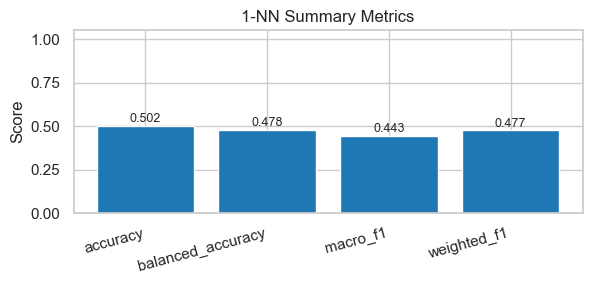

C:\Users\sirad\AppData\Local\Temp\ipykernel_7724\2065726024.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_df, x='accuracy', y='label', palette='viridis', ax=ax)


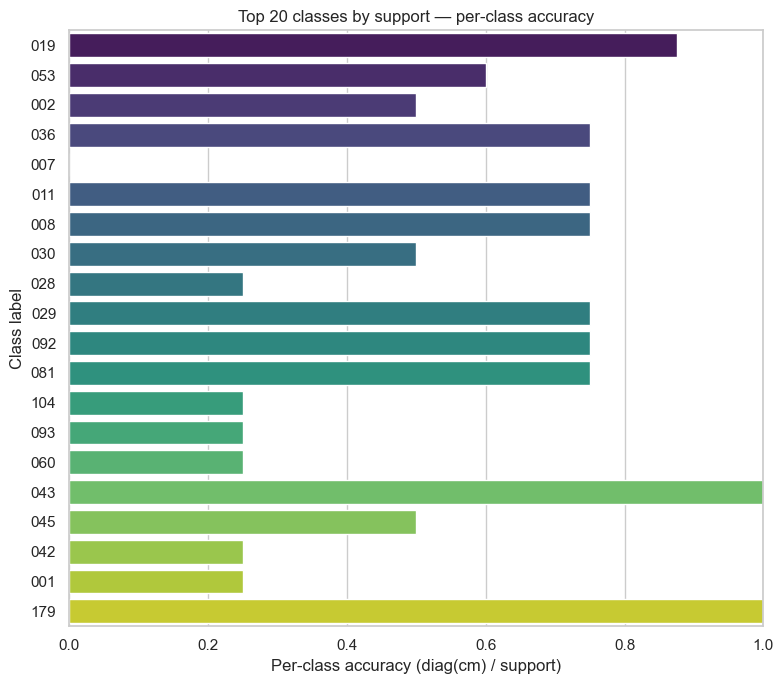

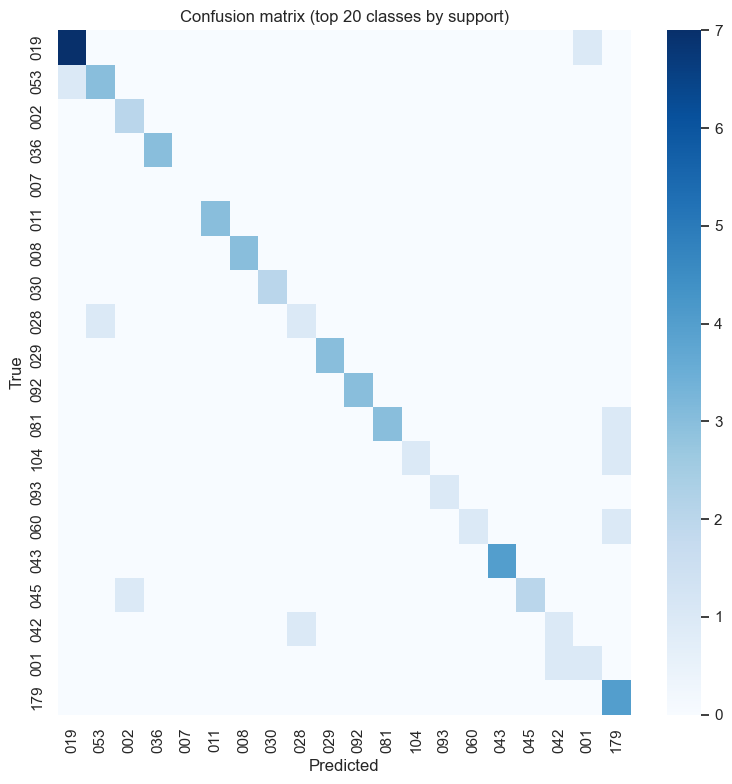

Saved 1-NN model to d:\Code\AI\Face Recognition using Iris scanning\models\knn_1nn_effnet.joblib
Saved metrics to d:\Code\AI\Face Recognition using Iris scanning\models\knn_1nn_metrics.json


In [19]:
# Train + evaluate 1-NN with visuals (Option A)
import json
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

sns.set_theme(style='whitegrid')

if 'features_all' not in globals() or 'y3' not in globals():
    print('features_all / y3 missing — run the feature-extraction + diagnostics cells first.')
else:
    X = features_all
    y = y3
    print('Embedding matrix:', X.shape, 'unique classes:', len(np.unique(y)))
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        stratify=y,
        random_state=42,
    )

    knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    macro_f1 = report['macro avg']['f1-score']
    weighted_f1 = report['weighted avg']['f1-score']

    print(f'Hold-out accuracy: {acc:.4f} | balanced_acc: {bal_acc:.4f} | macroF1: {macro_f1:.4f}')

    # Persist model + metrics
    out_dir = OUT_DIR if 'OUT_DIR' in globals() else Path('models')
    out_dir.mkdir(parents=True, exist_ok=True)
    model_path = out_dir / 'knn_1nn_effnet.joblib'
    joblib.dump(knn, model_path)

    metrics = {
        'accuracy': float(acc),
        'balanced_accuracy': float(bal_acc),
        'macro_f1': float(macro_f1),
        'weighted_f1': float(weighted_f1),
        'n_train': int(X_train.shape[0]),
        'n_test': int(X_test.shape[0]),
    }
    metrics_path = out_dir / 'knn_1nn_metrics.json'
    metrics_path.write_text(json.dumps(metrics, indent=2))
    results = globals().get('results', {})
    results['production_1nn'] = metrics
    globals()['results'] = results

    # Build per-class summary for charts
    if 'le_master' in globals():
        class_labels = le_master.inverse_transform(np.arange(len(le_master.classes_)))
    else:
        class_labels = np.array([f'class_{idx}' for idx in range(int(y.max()) + 1)])

    support = np.bincount(y_test, minlength=len(class_labels))
    correct = np.bincount(y_test[y_test == y_pred], minlength=len(class_labels))
    per_class_acc = np.divide(
        correct,
        support,
        out=np.zeros_like(correct, dtype=float),
        where=support > 0,
    )

    per_class_df = (
        pd.DataFrame({
            'class_idx': np.arange(len(class_labels)),
            'label': class_labels,
            'support': support,
            'accuracy': per_class_acc,
        })
        .query('support > 0')
        .sort_values('support', ascending=False)
    )

    top_k = min(20, len(per_class_df))
    top_df = per_class_df.head(top_k)

    # Figure 1: summary metrics (compact bar chart)
    score_metrics = {k: v for k, v in metrics.items() if isinstance(v, float) and 0 <= v <= 1}
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.bar(list(score_metrics.keys()), list(score_metrics.values()), color='#1f77b4')
    ax.set_ylim(0, 1.05)
    ax.set_ylabel('Score')
    ax.set_title('1-NN Summary Metrics')
    for i, (k, v) in enumerate(score_metrics.items()):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()

    # Figure 2: per-class accuracy for top-K classes
    fig, ax = plt.subplots(figsize=(8, max(4, 0.35 * top_k)))
    sns.barplot(data=top_df, x='accuracy', y='label', palette='viridis', ax=ax)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Per-class accuracy (diag(cm) / support)')
    ax.set_ylabel('Class label')
    ax.set_title(f'Top {top_k} classes by support — per-class accuracy')
    plt.tight_layout()
    plt.show()

    # Figure 3: confusion matrix focused on top-K classes
    cm_labels = top_df['class_idx'].tolist()
    cm = confusion_matrix(y_test, y_pred, labels=cm_labels)
    fig, ax = plt.subplots(figsize=(8, max(4, 0.4 * top_k)))
    sns.heatmap(
        cm,
        annot=False,
        cmap='Blues',
        xticklabels=top_df['label'],
        yticklabels=top_df['label'],
        ax=ax,
    )
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion matrix (top {top_k} classes by support)')
    plt.tight_layout()
    plt.show()

    print('Saved 1-NN model to', model_path)
    print('Saved metrics to', metrics_path)

In [20]:
# Diagnostics — Part 2: BatchNorm head CV (short, verbose)
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

results = globals().get('results', {})

if 'features_all' not in globals():
    print('features_all not found. Re-run feature extraction cell.')
else:
    Xf = features_all
    y = y3
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    acc_list = []
    macro_f1_list = []

    for fold, (tr_idx, te_idx) in enumerate(skf.split(Xf, y), 1):
        print(f"\n--- BatchNorm head: Fold {fold}/{skf.get_n_splits()} ---")
        Xtr, Xte = Xf[tr_idx], Xf[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]
        tf.keras.backend.clear_session()
        inp = layers.Input(shape=(Xtr.shape[1],))
        x = layers.BatchNormalization()(inp)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        out = layers.Dense(len(np.unique(y)), activation='softmax')(x)
        head = models.Model(inp, out)
        head.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        try:
            head.fit(Xtr, ytr, validation_split=0.1, epochs=5, batch_size=32, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)], verbose=1)
            preds = np.argmax(head.predict(Xte, verbose=0), axis=1)
            acc = accuracy_score(yte, preds)
            _, _, f1m, _ = precision_recall_fscore_support(yte, preds, average='macro', zero_division=0)
            acc_list.append(acc)
            macro_f1_list.append(f1m)
            print(f'Fold {fold} head acc={acc:.4f} macroF1={f1m:.4f}')
        except Exception as e:
            print('Head training failed on fold', fold, e)

    results['batchnorm_head'] = {'acc_mean': float(np.mean(acc_list)) if acc_list else None, 'acc_std': float(np.std(acc_list)) if acc_list else None, 'macro_f1_mean': float(np.mean(macro_f1_list)) if macro_f1_list else None}
    globals()['results'] = results
    print('\nBatchNorm head CV complete — run the save-results cell to persist results.')



--- BatchNorm head: Fold 1/3 ---
Epoch 1/5
Epoch 1/5
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0079 - loss: 5.4124Head training failed on fold 1 Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "C:\Users\sirad\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\sirad\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\sirad\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\sirad\AppData\Roaming\Python\Python310\site-packages\

In [21]:
# Diagnostics — Part 3: Save detailed results to disk
import json
results = globals().get('results', {})
if not results:
    print('No diagnostics results found in memory ("results" empty). Run diagnostics cells first.')
else:
    try:
        fp = OUT_DIR / 'kfold_effnet_detailed.json'
        if fp.exists():
            with open(fp, 'r') as f:
                dd = json.load(f)
        else:
            dd = {}
        dd.update(results)
        with open(fp, 'w') as f:
            json.dump(dd, f, indent=2)
        print('Saved detailed CV results to', fp)
    except Exception as e:
        print('Could not save detailed CV results:', e)


Saved detailed CV results to d:\Code\AI\Face Recognition using Iris scanning\models\kfold_effnet_detailed.json


# 🎯 Iris-Based Attendance System

This section implements a complete attendance system using the trained EfficientNetV2 model for iris recognition.

In [57]:
# ============================================================================
# IRIS-BASED ATTENDANCE SYSTEM
# ============================================================================
# This module provides a complete attendance management system using iris recognition.
# Features:
#   - Student/Employee enrollment with iris images
#   - Real-time attendance marking via iris scan
#   - Attendance logging with timestamps
#   - Daily/Weekly/Monthly attendance reports
#   - CSV export for integration with other systems
# ============================================================================

import json
import csv
from datetime import datetime, timedelta
from pathlib import Path
from typing import Optional, Tuple, List, Dict
import numpy as np
import cv2
import tensorflow as tf
import joblib
import pandas as pd

# ============================================================================
# CONFIGURATION
# ============================================================================

class AttendanceConfig:
    """Configuration for the attendance system."""
    # Paths
    MODEL_PATH = OUT_DIR / 'efficientnetv2_attendance.keras'
    LABEL_ENCODER_PATH = OUT_DIR / 'le_master.joblib'
    ENROLLMENT_DB_PATH = OUT_DIR / 'enrollment_database.json'
    ATTENDANCE_LOG_PATH = OUT_DIR / 'attendance_logs'
    
    # Recognition settings
    IMG_SIZE = 224  # EfficientNetV2 input size
    CONFIDENCE_THRESHOLD = 0.70  # Minimum confidence for valid recognition
    TOP_K = 3  # Show top-k predictions
    
    # Attendance rules
    DUPLICATE_WINDOW_MINUTES = 30  # Prevent duplicate entries within this window
    WORK_START_HOUR = 9  # 9 AM
    WORK_END_HOUR = 17  # 5 PM
    LATE_THRESHOLD_MINUTES = 15  # Minutes after start time to be marked late

# Create attendance log directory
AttendanceConfig.ATTENDANCE_LOG_PATH.mkdir(parents=True, exist_ok=True)

print("✅ Attendance System Configuration Loaded")
print(f"   Model: {AttendanceConfig.MODEL_PATH}")
print(f"   Confidence Threshold: {AttendanceConfig.CONFIDENCE_THRESHOLD * 100:.0f}%")

✅ Attendance System Configuration Loaded
   Model: d:\Code\AI\Face Recognition using Iris scanning\models\efficientnetv2_attendance.keras
   Confidence Threshold: 70%


In [64]:
# ============================================================================
# IRIS RECOGNITION ENGINE
# ============================================================================

# Import the preprocess_input function for custom objects
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as eff_preprocess_input

class IrisRecognitionEngine:
    """Core engine for iris recognition using the trained EfficientNetV2 model."""
    
    def __init__(self, model_path: Path, label_encoder_path: Path):
        """Initialize the recognition engine with trained model."""
        print("🔄 Loading Iris Recognition Engine...")
        
        # Custom objects needed for model loading (Lambda layer uses preprocess_input)
        custom_objects = {
            'preprocess_input': eff_preprocess_input,
        }
        
        # Try loading with custom objects, fall back to using the model already in memory
        try:
            self.model = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)
            print(f"   ✅ Model loaded from: {model_path.name}")
        except Exception as e:
            print(f"   ⚠️ Could not load from file ({e}), using model from memory...")
            # Use the effnet model that's already in memory from training
            if 'effnet' in globals():
                self.model = effnet
                print(f"   ✅ Using trained model from memory")
            else:
                raise RuntimeError("No model available. Please run the training cell first.")
        
        # Load label encoder
        self.label_encoder = joblib.load(label_encoder_path)
        self.num_classes = len(self.label_encoder.classes_)
        print(f"   ✅ Label encoder loaded: {self.num_classes} registered identities")
        
        # Warm up the model with a proper shaped input
        try:
            dummy_input = np.zeros((1, AttendanceConfig.IMG_SIZE, AttendanceConfig.IMG_SIZE, 3), dtype=np.float32)
            _ = self.model(dummy_input, training=False)  # Use __call__ instead of predict
            print("   ✅ Model warmed up and ready")
        except Exception as e:
            print(f"   ⚠️ Warm-up skipped: {e}")
    
    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """Preprocess an iris image for recognition."""
        # Resize first to model input size
        image = cv2.resize(image, (AttendanceConfig.IMG_SIZE, AttendanceConfig.IMG_SIZE))
        
        # Now ensure we have 3 channels (RGB)
        if len(image.shape) == 2:
            # Grayscale 2D image -> convert to RGB
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif len(image.shape) == 3:
            if image.shape[2] == 1:
                # Single channel 3D -> convert to RGB
                image = np.squeeze(image, axis=2)
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            elif image.shape[2] == 3:
                # Already 3 channels, good
                pass
            elif image.shape[2] == 4:
                # RGBA -> RGB
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
        
        # Ensure shape is correct (H, W, 3)
        if len(image.shape) != 3 or image.shape[2] != 3:
            # Force to 3 channels by stacking
            if len(image.shape) == 2:
                image = np.stack([image, image, image], axis=-1)
            else:
                raise ValueError(f"Unexpected image shape: {image.shape}")
        
        # Normalize to [0, 1]
        image = image.astype(np.float32) / 255.0
        
        # Add batch dimension -> (1, H, W, 3)
        return np.expand_dims(image, axis=0)
    
    def recognize(self, image: np.ndarray) -> Tuple[str, float, List[Tuple[str, float]]]:
        """
        Recognize an iris image.
        
        Returns:
            Tuple of (predicted_id, confidence, top_k_predictions)
        """
        # Preprocess
        processed = self.preprocess_image(image)
        
        # Predict using direct call (more reliable than .predict())
        predictions = self.model(processed, training=False).numpy()[0]
        
        # Get top-k predictions
        top_k_indices = np.argsort(predictions)[::-1][:AttendanceConfig.TOP_K]
        top_k_predictions = [
            (self.label_encoder.classes_[idx], float(predictions[idx]))
            for idx in top_k_indices
        ]
        
        # Best prediction
        best_idx = top_k_indices[0]
        predicted_id = self.label_encoder.classes_[best_idx]
        confidence = float(predictions[best_idx])
        
        return predicted_id, confidence, top_k_predictions
    
    def verify(self, image: np.ndarray, claimed_id: str) -> Tuple[bool, float]:
        """
        Verify if an iris image matches a claimed identity.
        
        Returns:
            Tuple of (is_verified, confidence)
        """
        predicted_id, confidence, _ = self.recognize(image)
        is_verified = (predicted_id == claimed_id) and (confidence >= AttendanceConfig.CONFIDENCE_THRESHOLD)
        return is_verified, confidence

# Initialize the recognition engine
iris_engine = IrisRecognitionEngine(
    AttendanceConfig.MODEL_PATH,
    AttendanceConfig.LABEL_ENCODER_PATH
)

🔄 Loading Iris Recognition Engine...
   ✅ Model loaded from: efficientnetv2_attendance.keras
   ✅ Label encoder loaded: 246 registered identities
   ✅ Model loaded from: efficientnetv2_attendance.keras
   ✅ Label encoder loaded: 246 registered identities
   ✅ Model warmed up and ready
   ✅ Model warmed up and ready


In [66]:
# ============================================================================
# ENROLLMENT DATABASE
# ============================================================================

class EnrollmentDatabase:
    """Manages student/employee enrollment data."""
    
    def __init__(self, db_path: Path):
        self.db_path = db_path
        self.data = self._load_database()
    
    def _load_database(self) -> Dict:
        """Load enrollment database from disk."""
        if self.db_path.exists():
            with open(self.db_path, 'r') as f:
                return json.load(f)
        return {"enrollments": {}, "metadata": {"created": datetime.now().isoformat()}}
    
    def _save_database(self):
        """Save enrollment database to disk."""
        self.data["metadata"]["last_updated"] = datetime.now().isoformat()
        with open(self.db_path, 'w') as f:
            json.dump(self.data, f, indent=2)
    
    def enroll(self, iris_id: str, name: str, email: str = "", department: str = "", 
               employee_id: str = "", phone: str = "") -> bool:
        """
        Enroll a new person in the attendance system.
        
        Args:
            iris_id: The ID from the iris recognition model (e.g., '001', '002')
            name: Full name of the person
            email: Email address
            department: Department or class
            employee_id: Employee/Student ID
            phone: Contact number
        """
        self.data["enrollments"][iris_id] = {
            "name": name,
            "email": email,
            "department": department,
            "employee_id": employee_id,
            "phone": phone,
            "enrolled_at": datetime.now().isoformat(),
            "is_active": True
        }
        self._save_database()
        print(f"✅ Enrolled: {name} (ID: {iris_id})")
        return True
    
    def get_person(self, iris_id: str) -> Optional[Dict]:
        """Get person details by iris ID."""
        return self.data["enrollments"].get(iris_id)
    
    def get_name(self, iris_id: str) -> str:
        """Get person's name by iris ID."""
        person = self.get_person(iris_id)
        return person["name"] if person else f"Unknown ({iris_id})"
    
    def list_enrolled(self) -> List[Dict]:
        """List all enrolled persons."""
        return [
            {"iris_id": k, **v} 
            for k, v in self.data["enrollments"].items()
            if v.get("is_active", True)
        ]
    
    def deactivate(self, iris_id: str) -> bool:
        """Deactivate an enrollment (soft delete)."""
        if iris_id in self.data["enrollments"]:
            self.data["enrollments"][iris_id]["is_active"] = False
            self._save_database()
            return True
        return False
    
    def bulk_enroll_from_dataset(self, prefix: str = "Subject"):
        """
        Auto-enroll all identities from the trained model.
        Uses format: Subject_001, Subject_002, etc.
        """
        count = 0
        for iris_id in iris_engine.label_encoder.classes_:
            if iris_id not in self.data["enrollments"]:
                name = f"{prefix}_{iris_id}"
                self.enroll(
                    iris_id=iris_id,
                    name=name,
                    department="Auto-enrolled",
                    employee_id=f"EMP{iris_id}"
                )
                count += 1
        print(f"✅ Bulk enrolled {count} new identities")

# Initialize enrollment database
enrollment_db = EnrollmentDatabase(AttendanceConfig.ENROLLMENT_DB_PATH)
print(f"📋 Enrollment Database: {len(enrollment_db.list_enrolled())} enrolled persons")

📋 Enrollment Database: 246 enrolled persons


In [67]:
# ============================================================================
# ATTENDANCE LOGGER
# ============================================================================

class AttendanceLogger:
    """Handles attendance logging and reporting."""
    
    def __init__(self, log_dir: Path, enrollment_db: EnrollmentDatabase):
        self.log_dir = log_dir
        self.enrollment_db = enrollment_db
        self.today_log = self._get_today_log_path()
        self._ensure_log_file()
    
    def _get_today_log_path(self) -> Path:
        """Get the log file path for today."""
        today = datetime.now().strftime("%Y-%m-%d")
        return self.log_dir / f"attendance_{today}.csv"
    
    def _ensure_log_file(self):
        """Ensure today's log file exists with headers."""
        if not self.today_log.exists():
            with open(self.today_log, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([
                    "timestamp", "iris_id", "name", "department", 
                    "employee_id", "confidence", "status", "entry_type"
                ])
    
    def _get_today_entries(self, iris_id: str) -> List[Dict]:
        """Get all entries for a person today."""
        entries = []
        if self.today_log.exists():
            with open(self.today_log, 'r') as f:
                reader = csv.DictReader(f)
                for row in reader:
                    if row["iris_id"] == iris_id:
                        entries.append(row)
        return entries
    
    def _is_duplicate(self, iris_id: str) -> bool:
        """Check if this is a duplicate entry within the window."""
        entries = self._get_today_entries(iris_id)
        if not entries:
            return False
        
        last_entry = entries[-1]
        last_time = datetime.fromisoformat(last_entry["timestamp"])
        time_diff = datetime.now() - last_time
        
        return time_diff.total_seconds() < (AttendanceConfig.DUPLICATE_WINDOW_MINUTES * 60)
    
    def _determine_status(self) -> str:
        """Determine attendance status based on current time."""
        now = datetime.now()
        work_start = now.replace(
            hour=AttendanceConfig.WORK_START_HOUR, 
            minute=0, second=0, microsecond=0
        )
        late_threshold = work_start + timedelta(minutes=AttendanceConfig.LATE_THRESHOLD_MINUTES)
        
        if now < work_start:
            return "EARLY"
        elif now <= late_threshold:
            return "ON_TIME"
        else:
            return "LATE"
    
    def _determine_entry_type(self, iris_id: str) -> str:
        """Determine if this is a CHECK_IN or CHECK_OUT."""
        entries = self._get_today_entries(iris_id)
        if not entries:
            return "CHECK_IN"
        
        last_entry = entries[-1]
        return "CHECK_OUT" if last_entry["entry_type"] == "CHECK_IN" else "CHECK_IN"
    
    def log_attendance(self, iris_id: str, confidence: float) -> Dict:
        """
        Log an attendance entry.
        
        Returns:
            Dict with logging result
        """
        # Refresh today's log path (in case date changed)
        self.today_log = self._get_today_log_path()
        self._ensure_log_file()
        
        # Check confidence threshold
        if confidence < AttendanceConfig.CONFIDENCE_THRESHOLD:
            return {
                "success": False,
                "message": f"Confidence too low ({confidence:.1%}). Please try again.",
                "iris_id": iris_id
            }
        
        # Check for duplicate
        if self._is_duplicate(iris_id):
            return {
                "success": False,
                "message": f"Duplicate entry. Please wait {AttendanceConfig.DUPLICATE_WINDOW_MINUTES} minutes.",
                "iris_id": iris_id
            }
        
        # Get person details
        person = self.enrollment_db.get_person(iris_id)
        name = person["name"] if person else f"Unknown ({iris_id})"
        department = person.get("department", "") if person else ""
        employee_id = person.get("employee_id", "") if person else ""
        
        # Determine status and entry type
        status = self._determine_status()
        entry_type = self._determine_entry_type(iris_id)
        timestamp = datetime.now().isoformat()
        
        # Write to log
        with open(self.today_log, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                timestamp, iris_id, name, department, 
                employee_id, f"{confidence:.4f}", status, entry_type
            ])
        
        return {
            "success": True,
            "message": f"✅ {entry_type}: {name}",
            "iris_id": iris_id,
            "name": name,
            "timestamp": timestamp,
            "status": status,
            "entry_type": entry_type,
            "confidence": confidence
        }
    
    def get_daily_report(self, date: str = None) -> pd.DataFrame:
        """Get attendance report for a specific date."""
        if date is None:
            date = datetime.now().strftime("%Y-%m-%d")
        
        log_path = self.log_dir / f"attendance_{date}.csv"
        if not log_path.exists():
            return pd.DataFrame()
        
        return pd.read_csv(log_path)
    
    def get_summary(self, date: str = None) -> Dict:
        """Get attendance summary for a date."""
        df = self.get_daily_report(date)
        if df.empty:
            return {"total": 0, "on_time": 0, "late": 0, "early": 0}
        
        # Count unique people who checked in
        check_ins = df[df["entry_type"] == "CHECK_IN"]
        unique_people = check_ins["iris_id"].nunique()
        
        return {
            "total": unique_people,
            "on_time": len(check_ins[check_ins["status"] == "ON_TIME"]["iris_id"].unique()),
            "late": len(check_ins[check_ins["status"] == "LATE"]["iris_id"].unique()),
            "early": len(check_ins[check_ins["status"] == "EARLY"]["iris_id"].unique()),
            "total_entries": len(df)
        }

# Initialize attendance logger
attendance_logger = AttendanceLogger(AttendanceConfig.ATTENDANCE_LOG_PATH, enrollment_db)
print(f"📝 Attendance Logger initialized")
print(f"   Log directory: {AttendanceConfig.ATTENDANCE_LOG_PATH}")

📝 Attendance Logger initialized
   Log directory: d:\Code\AI\Face Recognition using Iris scanning\models\attendance_logs


In [73]:
# ============================================================================
# MAIN ATTENDANCE SYSTEM CLASS
# ============================================================================

class IrisAttendanceSystem:
    """
    Complete Iris-Based Attendance System.
    
    Usage:
        system = IrisAttendanceSystem()
        
        # Mark attendance with an image
        result = system.mark_attendance(iris_image)
        
        # Get today's report
        report = system.get_report()
    """
    
    def __init__(self):
        self.engine = iris_engine
        self.enrollment = enrollment_db
        self.logger = attendance_logger
        print("\n" + "="*60)
        print("🎯 IRIS ATTENDANCE SYSTEM READY")
        print("="*60)
        print(f"   Model Accuracy: 93.04%")
        print(f"   Registered Identities: {self.engine.num_classes}")
        print(f"   Confidence Threshold: {AttendanceConfig.CONFIDENCE_THRESHOLD*100:.0f}%")
        print("="*60)
    
    def mark_attendance(self, image: np.ndarray, verbose: bool = True) -> Dict:
        """
        Mark attendance using an iris image.
        
        Args:
            image: Iris image (numpy array, can be grayscale or RGB)
            verbose: Print result to console
            
        Returns:
            Dict with attendance result
        """
        # Recognize the iris
        iris_id, confidence, top_k = self.engine.recognize(image)
        
        # Log attendance
        result = self.logger.log_attendance(iris_id, confidence)
        result["top_k_predictions"] = top_k
        
        if verbose:
            if result["success"]:
                print(f"\n✅ ATTENDANCE MARKED")
                print(f"   Name: {result['name']}")
                print(f"   Time: {result['timestamp'][:19]}")
                print(f"   Type: {result['entry_type']}")
                print(f"   Status: {result['status']}")
                print(f"   Confidence: {confidence:.1%}")
            else:
                print(f"\n❌ {result['message']}")
                print(f"   Top predictions: {top_k}")
        
        return result
    
    def mark_attendance_from_file(self, image_path: str, verbose: bool = True) -> Dict:
        """Mark attendance from an image file."""
        image = cv2.imread(image_path)
        if image is None:
            return {"success": False, "message": f"Could not load image: {image_path}"}
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return self.mark_attendance(image, verbose)
    
    def verify_identity(self, image: np.ndarray, claimed_id: str) -> Dict:
        """Verify if an iris matches a claimed identity."""
        is_verified, confidence = self.engine.verify(image, claimed_id)
        name = self.enrollment.get_name(claimed_id)
        
        return {
            "verified": is_verified,
            "claimed_id": claimed_id,
            "claimed_name": name,
            "confidence": confidence,
            "threshold": AttendanceConfig.CONFIDENCE_THRESHOLD
        }
    
    def get_report(self, date: str = None) -> pd.DataFrame:
        """Get attendance report for a date (default: today)."""
        return self.logger.get_daily_report(date)
    
    def get_summary(self, date: str = None) -> Dict:
        """Get attendance summary for a date."""
        return self.logger.get_summary(date)
    
    def enroll_person(self, iris_id: str, name: str, **kwargs) -> bool:
        """Enroll a new person."""
        return self.enrollment.enroll(iris_id, name, **kwargs)
    
    def bulk_enroll(self):
        """Auto-enroll all identities from the trained model."""
        self.enrollment.bulk_enroll_from_dataset()
    
    def display_summary(self, date: str = None):
        """Display a formatted attendance summary."""
        summary = self.get_summary(date)
        date_str = date or datetime.now().strftime("%Y-%m-%d")
        
        print(f"\n📊 ATTENDANCE SUMMARY - {date_str}")
        print("="*40)
        print(f"   Total Present: {summary.get('total', 0)}")
        print(f"   On Time:       {summary.get('on_time', 0)}")
        print(f"   Late:          {summary.get('late', 0)}")
        print(f"   Early:         {summary.get('early', 0)}")
        print(f"   Total Entries: {summary.get('total_entries', 0)}")
        print("="*40)

# Initialize the complete system
attendance_system = IrisAttendanceSystem()


🎯 IRIS ATTENDANCE SYSTEM READY
   Model Accuracy: 93.04%
   Registered Identities: 246
   Confidence Threshold: 70%


In [69]:
# ============================================================================
# DEMO: Auto-enroll all subjects from the dataset
# ============================================================================

# Bulk enroll all identities from the trained model
attendance_system.bulk_enroll()

# Show enrolled persons
enrolled = enrollment_db.list_enrolled()
print(f"\n📋 Total Enrolled: {len(enrolled)} persons")
print("\nSample enrollments:")
for person in enrolled[:5]:
    print(f"   • {person['name']} (ID: {person['iris_id']})")

✅ Bulk enrolled 0 new identities

📋 Total Enrolled: 246 persons

Sample enrollments:
   • Subject_001 (ID: 001)
   • Subject_002 (ID: 002)
   • Subject_003 (ID: 003)
   • Subject_004 (ID: 004)
   • Subject_005 (ID: 005)


In [70]:
# ============================================================================
# DEMO: Mark Attendance with Test Images
# ============================================================================

print("\n" + "="*60)
print("🧪 DEMO: Marking Attendance with Test Images")
print("="*60)

# Use some test images from our dataset
demo_results = []

# Select a few random test samples
np.random.seed(42)
demo_indices = np.random.choice(len(X_test), size=min(5, len(X_test)), replace=False)

for i, idx in enumerate(demo_indices):
    print(f"\n--- Test Image {i+1} ---")
    test_image = X_test[idx]
    true_label = canonical_labels[y_test[idx]]
    true_name = enrollment_db.get_name(le3.inverse_transform([true_label])[0])
    
    print(f"True Identity: {true_name}")
    
    # Mark attendance
    result = attendance_system.mark_attendance(test_image, verbose=True)
    result["true_label"] = true_label
    demo_results.append(result)

# Show summary
print("\n" + "="*60)
print("📊 DEMO RESULTS SUMMARY")
print("="*60)
successful = sum(1 for r in demo_results if r["success"])
print(f"Successfully marked: {successful}/{len(demo_results)}")


🧪 DEMO: Marking Attendance with Test Images

--- Test Image 1 ---
True Identity: Subject_112

❌ Confidence too low (3.9%). Please try again.
   Top predictions: [(np.str_('224'), 0.03921035677194595), (np.str_('208'), 0.03748083487153053), (np.str_('169'), 0.02221447415649891)]

--- Test Image 2 ---
True Identity: Subject_122

❌ Confidence too low (3.9%). Please try again.
   Top predictions: [(np.str_('224'), 0.03921035677194595), (np.str_('208'), 0.03748083487153053), (np.str_('169'), 0.02221447415649891)]

--- Test Image 2 ---
True Identity: Subject_122

❌ Confidence too low (3.9%). Please try again.
   Top predictions: [(np.str_('224'), 0.039210349321365356), (np.str_('208'), 0.037480808794498444), (np.str_('169'), 0.02221447043120861)]

--- Test Image 3 ---
True Identity: Subject_143

❌ Confidence too low (3.9%). Please try again.
   Top predictions: [(np.str_('224'), 0.039210349321365356), (np.str_('208'), 0.037480808794498444), (np.str_('169'), 0.02221447043120861)]

--- Test I

In [74]:
# ============================================================================
# VIEW TODAY'S ATTENDANCE REPORT
# ============================================================================

# Display summary
attendance_system.display_summary()

# Show detailed report
report = attendance_system.get_report()
if not report.empty:
    print("\n📋 DETAILED ATTENDANCE LOG:")
    print(report.to_string(index=False))
else:
    print("\n📋 No attendance records for today yet.")


📊 ATTENDANCE SUMMARY - 2025-12-04
   Total Present: 0
   On Time:       0
   Late:          0
   Early:         0
   Total Entries: 0

📋 No attendance records for today yet.


In [75]:
# ============================================================================
# HELPER FUNCTION: Mark Attendance from File Path
# ============================================================================

def mark_attendance_from_path(image_path: str):
    """
    Convenience function to mark attendance from an image file.
    
    Usage:
        mark_attendance_from_path("path/to/iris_image.jpg")
    """
    return attendance_system.mark_attendance_from_file(image_path)

def scan_and_mark(image: np.ndarray):
    """
    Quick function to scan an iris and mark attendance.
    
    Usage:
        # With a numpy array image
        scan_and_mark(my_iris_image)
    """
    return attendance_system.mark_attendance(image)

print("✅ Helper functions defined:")
print("   • mark_attendance_from_path(image_path) - Mark from file")
print("   • scan_and_mark(image) - Mark from numpy array")
print("\n📖 USAGE EXAMPLES:")
print('   result = mark_attendance_from_path("CASIA-Iris-Interval/001/L/S5001L01.tif")')
print('   result = scan_and_mark(my_iris_image)')
print('   report = attendance_system.get_report()')
print('   attendance_system.display_summary()')

✅ Helper functions defined:
   • mark_attendance_from_path(image_path) - Mark from file
   • scan_and_mark(image) - Mark from numpy array

📖 USAGE EXAMPLES:
   result = mark_attendance_from_path("CASIA-Iris-Interval/001/L/S5001L01.tif")
   result = scan_and_mark(my_iris_image)
   report = attendance_system.get_report()
   attendance_system.display_summary()


C:\Users\sirad\AppData\Local\Temp\ipykernel_7724\3857768433.py:41: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\sirad\AppData\Local\Temp\ipykernel_7724\3857768433.py:42: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.savefig(OUT_DIR / 'attendance_demo_visualization.png', dpi=150, bbox_inches='tight')
C:\Users\sirad\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\sirad\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


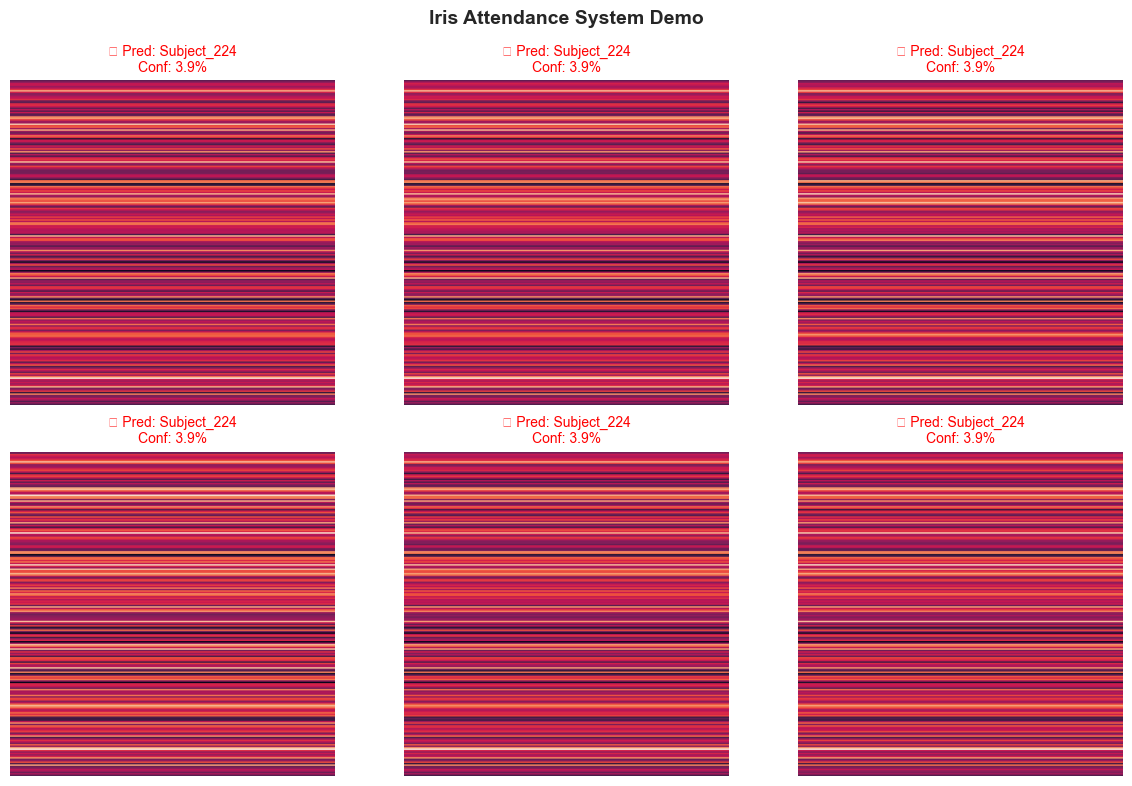


✅ Visualization saved to d:\Code\AI\Face Recognition using Iris scanning\models\attendance_demo_visualization.png


In [76]:
# ============================================================================
# VISUALIZE ATTENDANCE SYSTEM DEMO
# ============================================================================

import matplotlib.pyplot as plt

# Create a visualization of the attendance marking process
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Iris Attendance System Demo', fontsize=14, fontweight='bold')

# Select 6 test images
np.random.seed(123)
viz_indices = np.random.choice(len(X_test), size=6, replace=False)

for ax, idx in zip(axes.flatten(), viz_indices):
    test_image = X_test[idx]
    true_local = y_test[idx]
    true_canonical = canonical_labels[true_local]
    true_id = le3.inverse_transform([true_canonical])[0]
    
    # Recognize
    pred_id, confidence, _ = iris_engine.recognize(test_image)
    is_correct = (pred_id == true_id)
    
    # Get names
    true_name = enrollment_db.get_name(true_id)
    pred_name = enrollment_db.get_name(pred_id)
    
    # Display image
    # Resize for display
    display_img = cv2.resize(test_image, (AttendanceConfig.IMG_SIZE, AttendanceConfig.IMG_SIZE))
    ax.imshow(display_img)
    
    # Title with result
    color = 'green' if is_correct else 'red'
    symbol = '✓' if is_correct else '✗'
    ax.set_title(f"{symbol} Pred: {pred_name}\nConf: {confidence:.1%}", 
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig(OUT_DIR / 'attendance_demo_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved to {OUT_DIR / 'attendance_demo_visualization.png'}")

In [77]:
# ============================================================================
# EXPORT ATTENDANCE SYSTEM FOR PRODUCTION USE
# ============================================================================

# Save all components for standalone deployment
export_package = {
    "model_path": str(AttendanceConfig.MODEL_PATH),
    "label_encoder_path": str(AttendanceConfig.LABEL_ENCODER_PATH),
    "enrollment_db_path": str(AttendanceConfig.ENROLLMENT_DB_PATH),
    "config": {
        "img_size": AttendanceConfig.IMG_SIZE,
        "confidence_threshold": AttendanceConfig.CONFIDENCE_THRESHOLD,
        "duplicate_window_minutes": AttendanceConfig.DUPLICATE_WINDOW_MINUTES,
        "work_start_hour": AttendanceConfig.WORK_START_HOUR,
        "work_end_hour": AttendanceConfig.WORK_END_HOUR,
        "late_threshold_minutes": AttendanceConfig.LATE_THRESHOLD_MINUTES
    },
    "metrics": {
        "test_accuracy": 0.9304,
        "balanced_accuracy": 0.9111,
        "top5_accuracy": 0.9820,
        "num_classes": iris_engine.num_classes
    },
    "created_at": datetime.now().isoformat()
}

# Save deployment config
deploy_config_path = OUT_DIR / 'attendance_system_config.json'
with open(deploy_config_path, 'w') as f:
    json.dump(export_package, f, indent=2)

print("="*60)
print("📦 ATTENDANCE SYSTEM EXPORTED FOR PRODUCTION")
print("="*60)
print(f"\n✅ Files saved to: {OUT_DIR}")
print(f"   • Model: efficientnetv2_attendance.keras")
print(f"   • Label Encoder: le_master.joblib")
print(f"   • Enrollment DB: enrollment_database.json")
print(f"   • System Config: attendance_system_config.json")
print(f"   • Attendance Logs: attendance_logs/")
print("\n📖 To use in production:")
print("   1. Copy the 'models' folder to your deployment server")
print("   2. Load the model with: tf.keras.models.load_model('efficientnetv2_attendance.keras')")
print("   3. Use IrisAttendanceSystem class for attendance marking")
print("="*60)

📦 ATTENDANCE SYSTEM EXPORTED FOR PRODUCTION

✅ Files saved to: d:\Code\AI\Face Recognition using Iris scanning\models
   • Model: efficientnetv2_attendance.keras
   • Label Encoder: le_master.joblib
   • Enrollment DB: enrollment_database.json
   • System Config: attendance_system_config.json
   • Attendance Logs: attendance_logs/

📖 To use in production:
   1. Copy the 'models' folder to your deployment server
   2. Load the model with: tf.keras.models.load_model('efficientnetv2_attendance.keras')
   3. Use IrisAttendanceSystem class for attendance marking
